In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import shap
from shap.plots import bar
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [3]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [4]:
def load(focus_class):
    with open(f'clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

# Generate Explanations

In [5]:
%%time

indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='indiv', space_type='log_odds')
with open('indiv.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
    
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 247it [03:21,  1.18it/s]                         
Exact explainer: 247it [06:32,  1.64s/it]                         

CPU times: user 11min 49s, sys: 1min 57s, total: 13min 46s
Wall time: 9min 53s


In [9]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
CPU times: user 22min 10s, sys: 10 s, total: 22min 20s
Wall time: 23min 7s


# Individual Explanations

In [7]:
with open('indiv.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

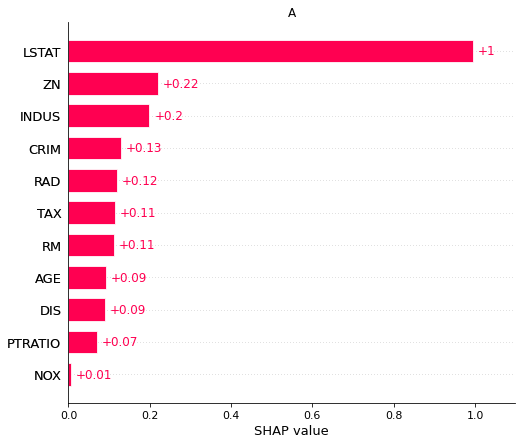

In [4]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

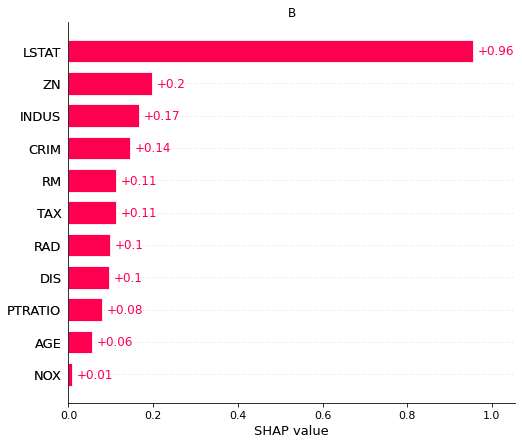

In [5]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [8]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

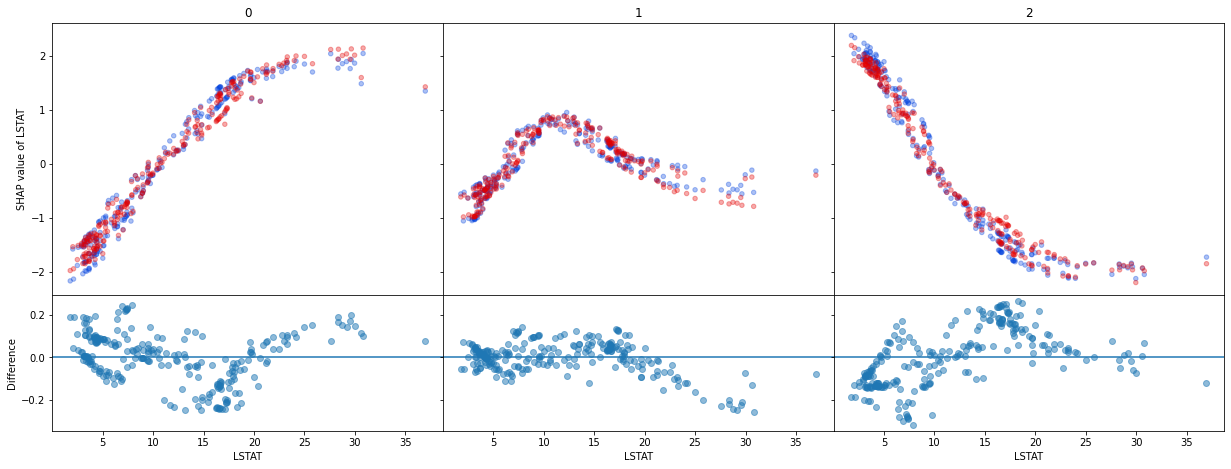

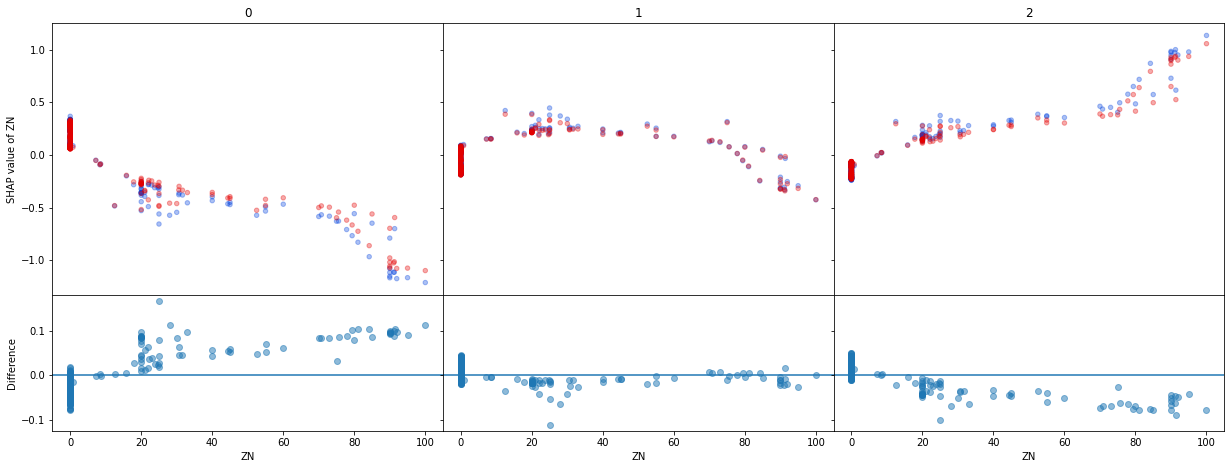

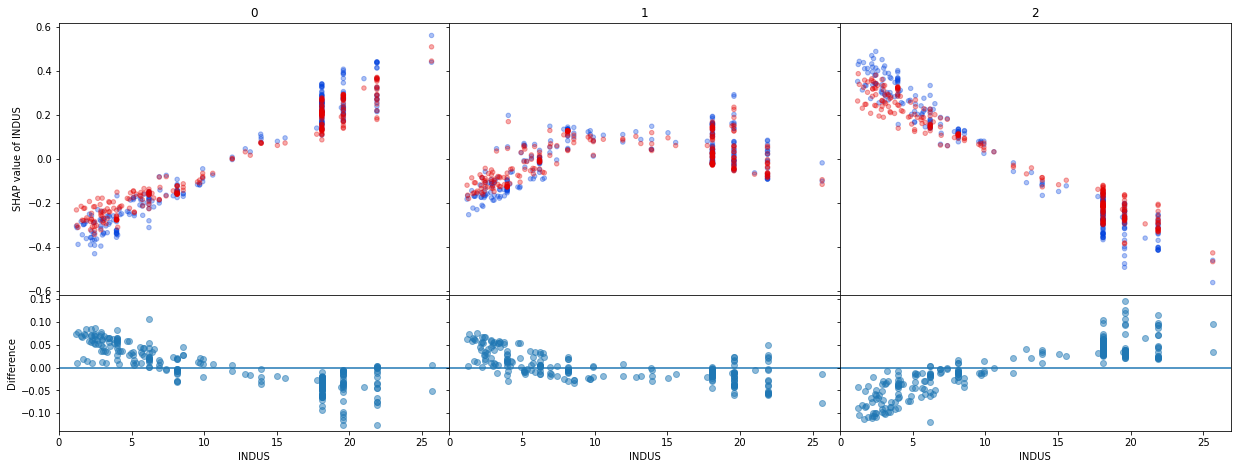

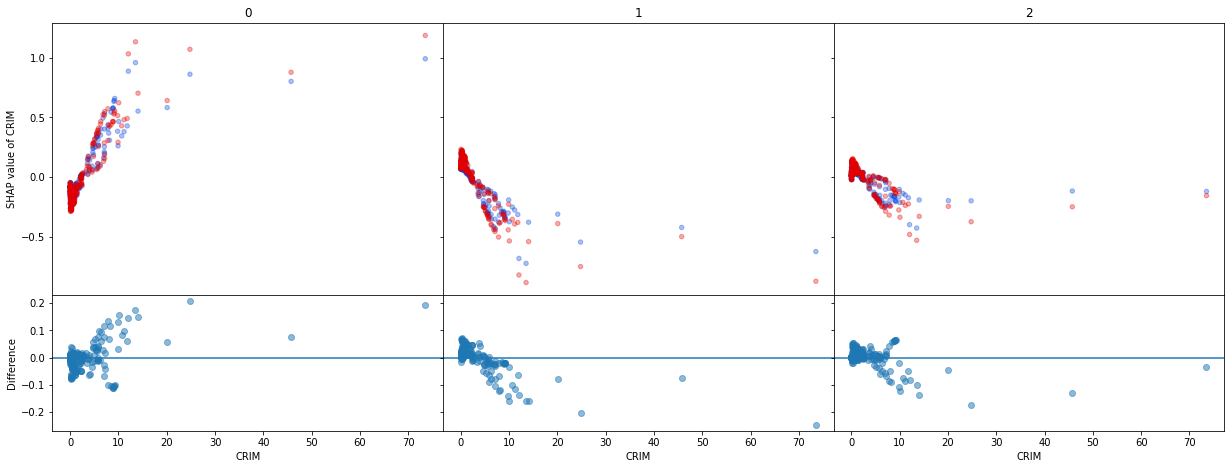

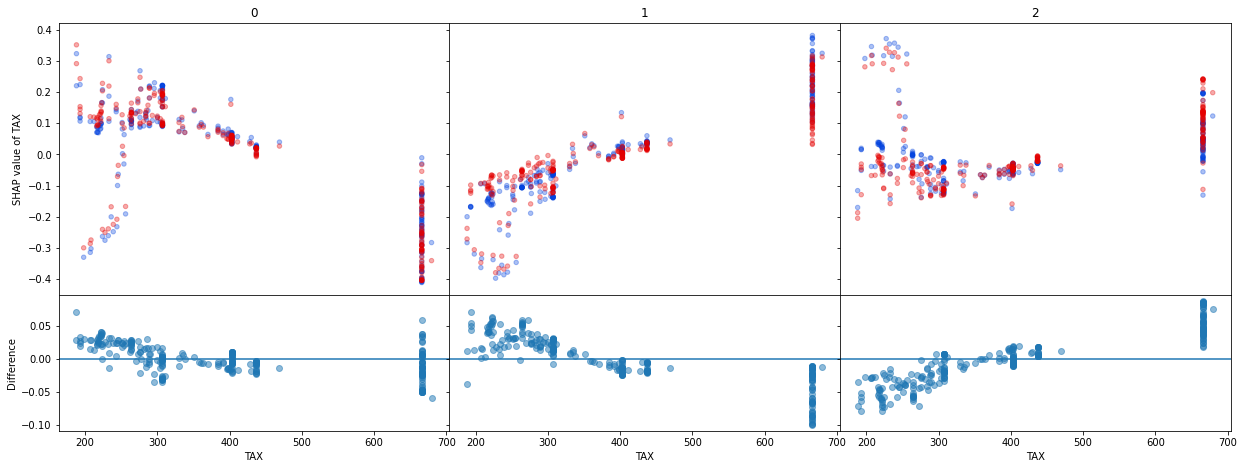

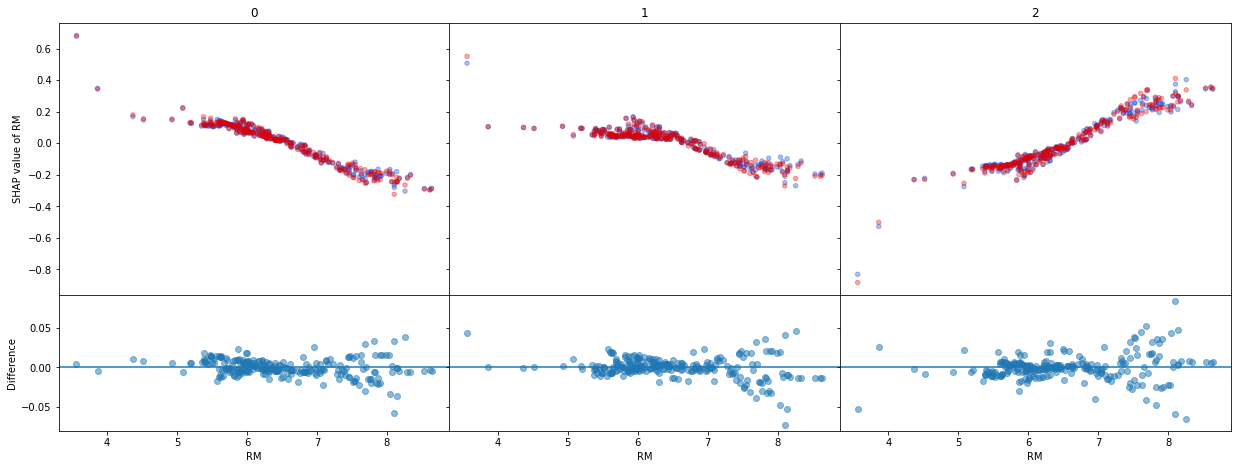

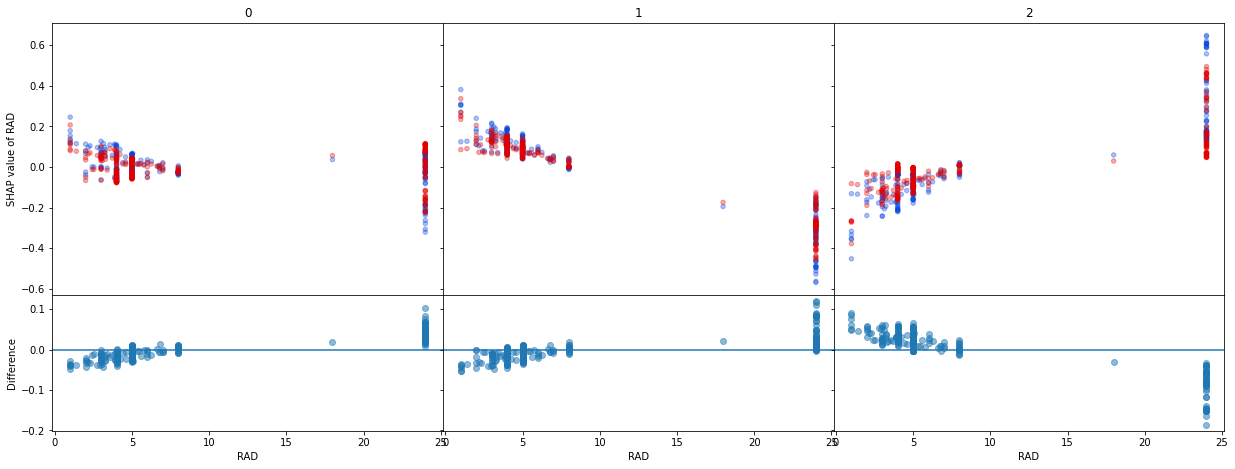

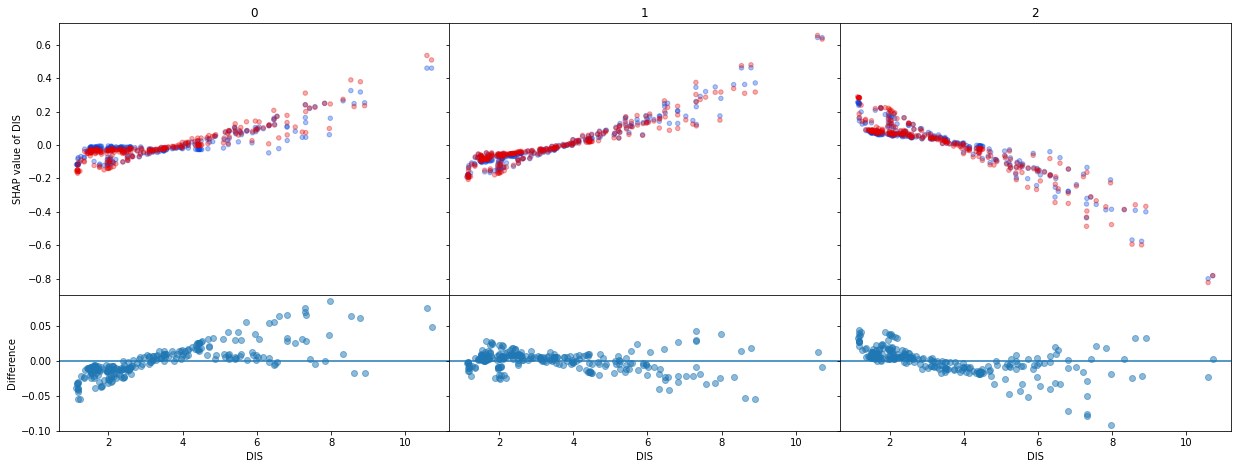

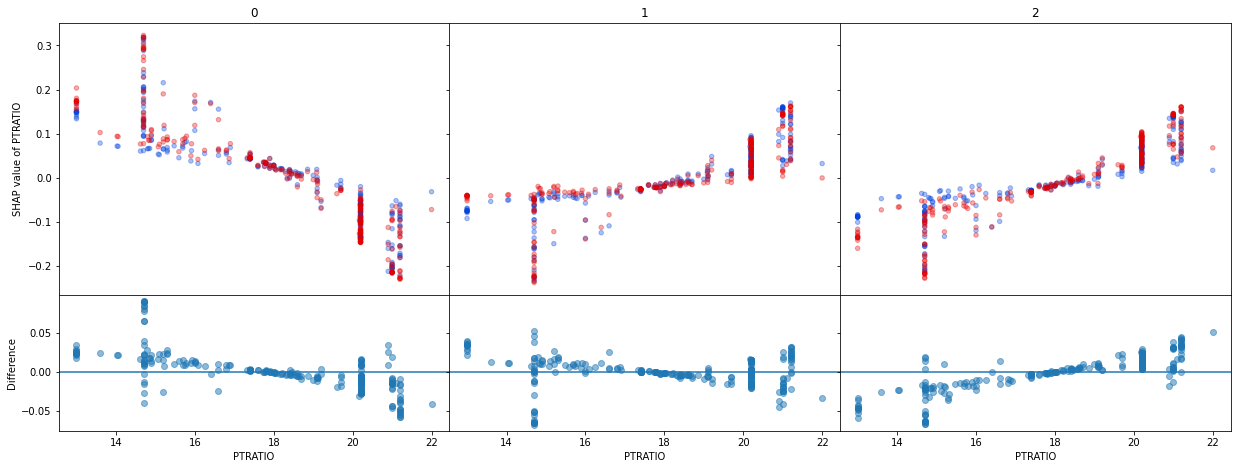

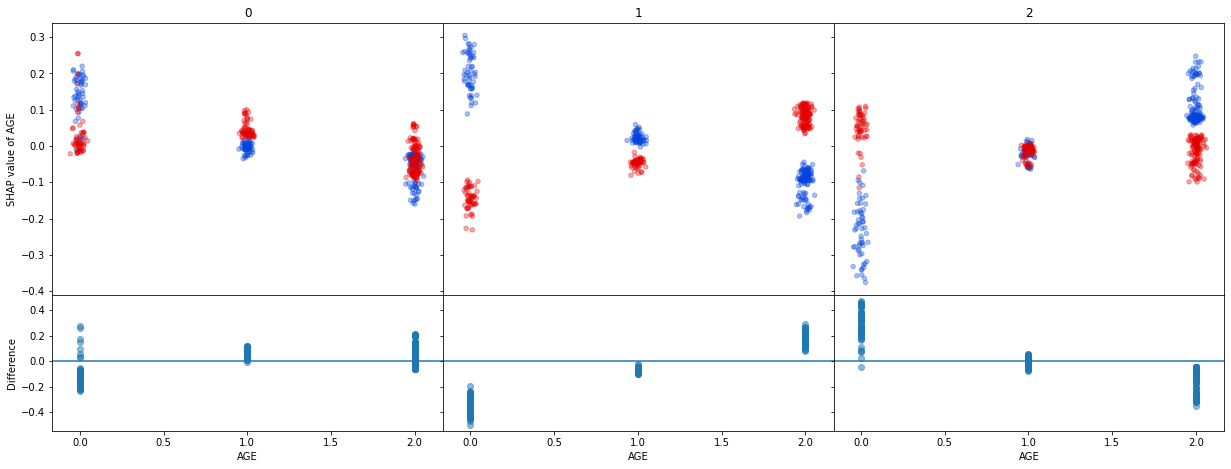

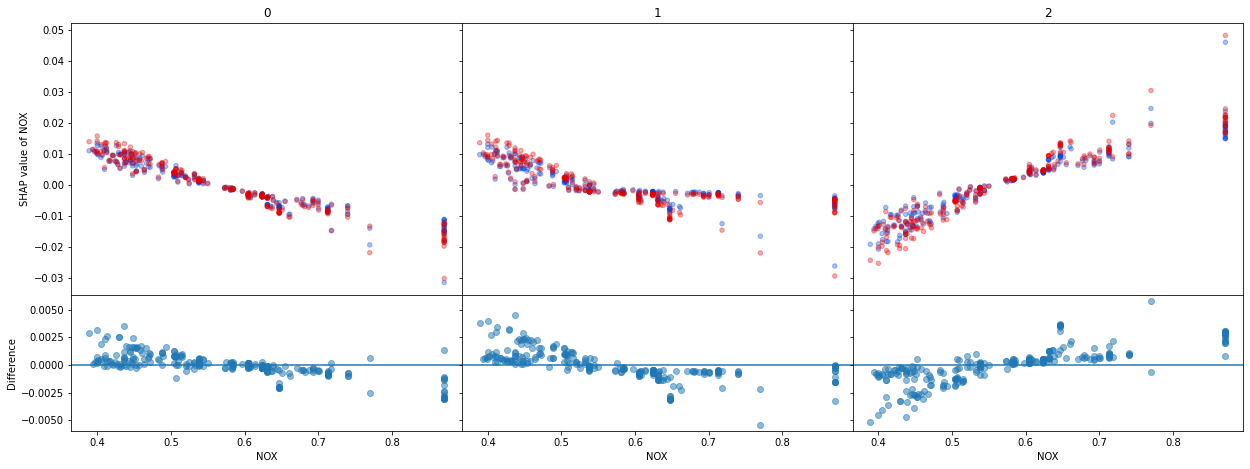

In [9]:
for feature in node.features_ordered:
    compare_indiv_dep_plots(node, feature)
    plt.show()

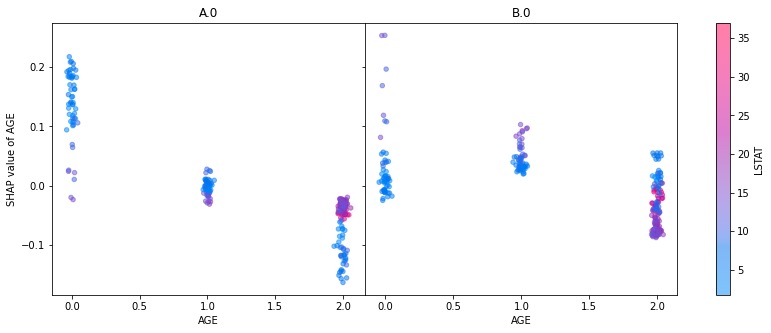

In [73]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.0'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.0', 'B.0'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

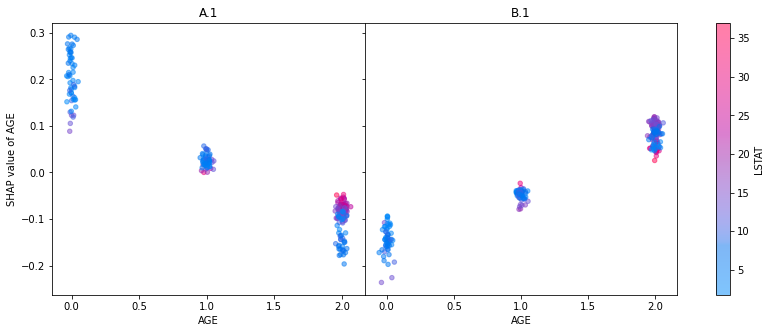

In [78]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.1'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.1', 'B.1'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

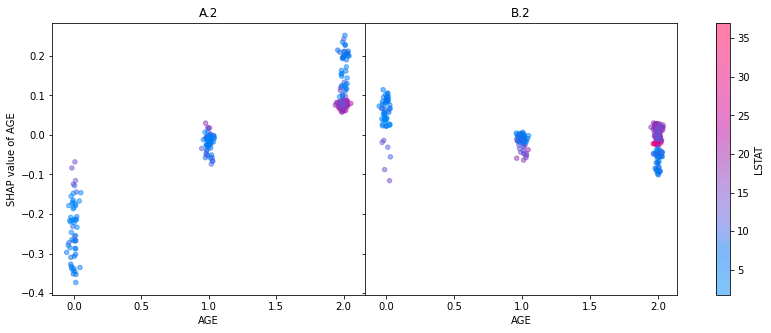

In [81]:
feature_interaction_order = estimate_feature_interaction_order(indiv_shap_values[:, :, 'A.2'], 'AGE')
node.plot_feature_dependence('AGE', classes=['A.2', 'B.2'], alpha=0.5,
                             color=int(feature_interaction_order[0]))

# Difference Classifier Explanations

In [5]:
with open('diffclf.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

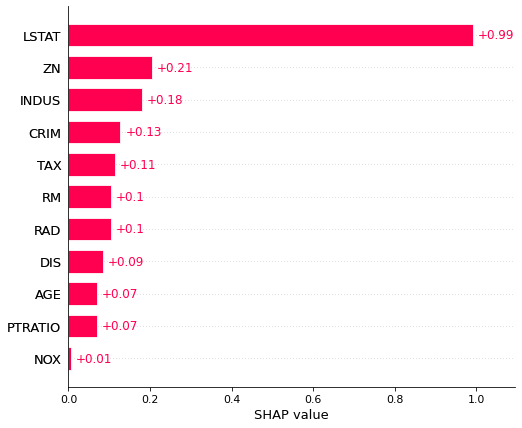

In [6]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [7]:
node = load('(0, 1)')
node.class_counts, node.distance
classes = ['(0, 0)', '(0, 1)', '(1, 0)', '(1, 1)']

### Main Node (L)

In [8]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(L,
 (0, 0)    76
 (1, 1)    35
 (0, 1)    13
 dtype: int64,
 46.55321433725376)

11.1 <= LSTAT <= 18.72
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 13},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 13}]


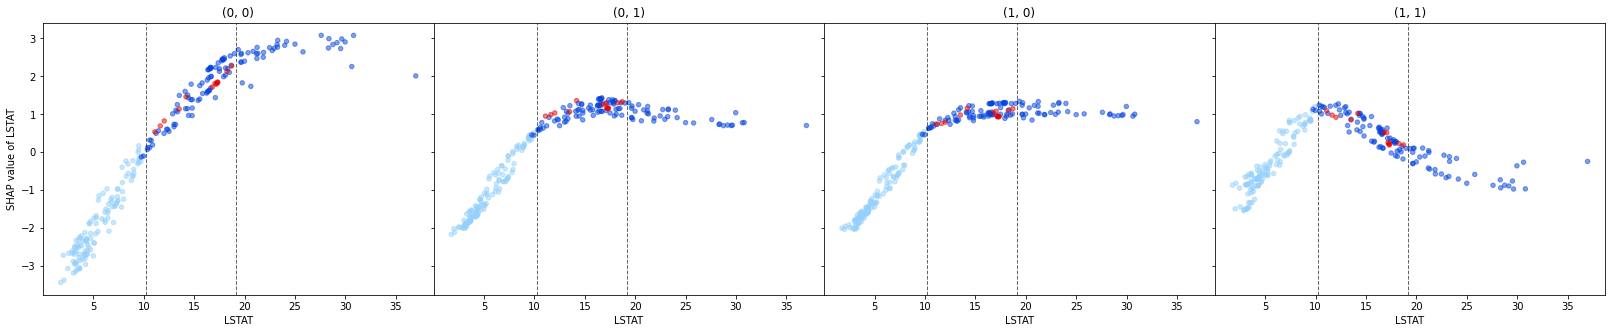

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 13}]


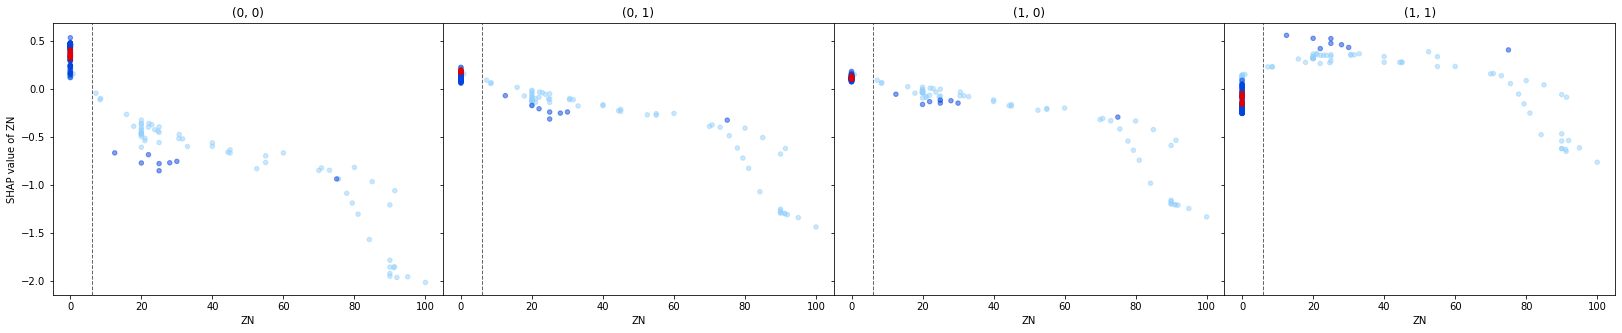

8.14 <= INDUS <= 21.89
[]


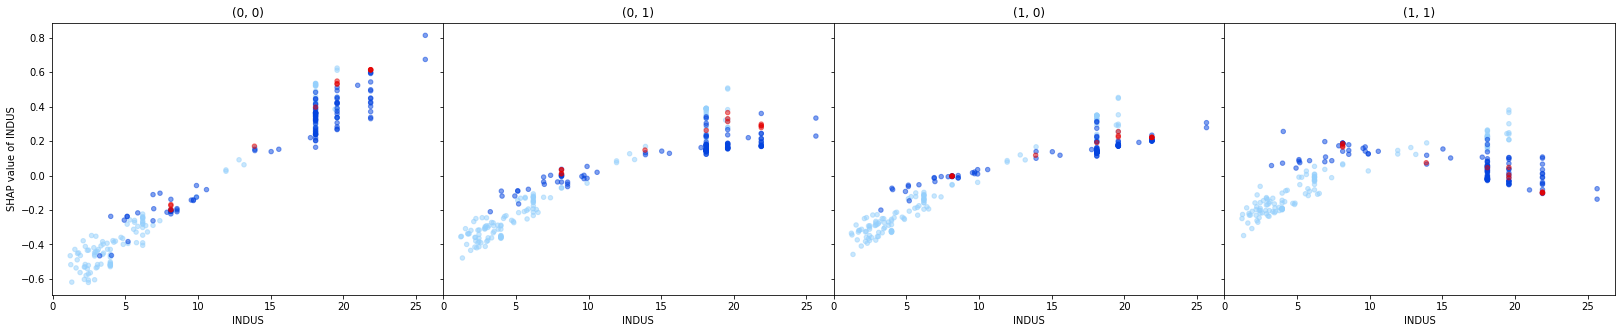

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 6.2 --> {'(0, 0)': 13}]


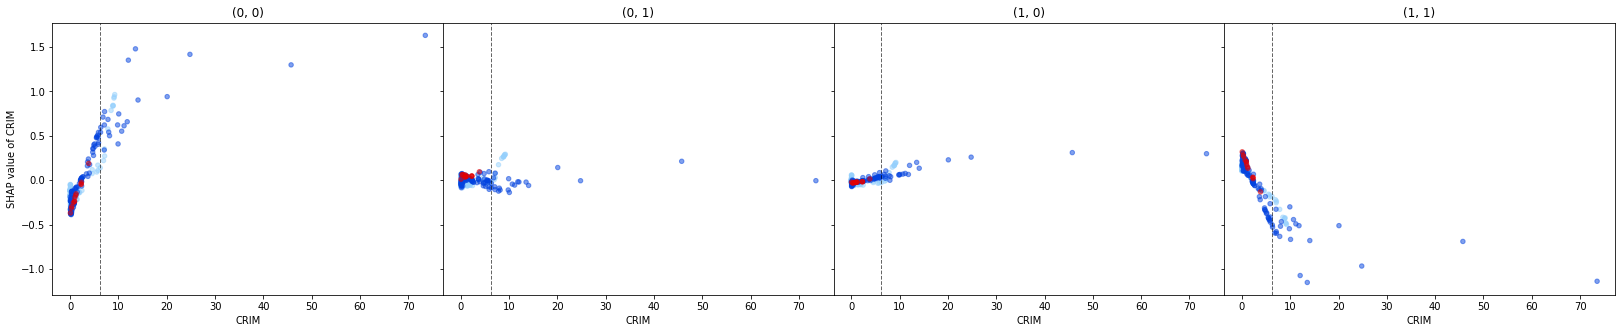

276.0 <= TAX <= 666.0
[]


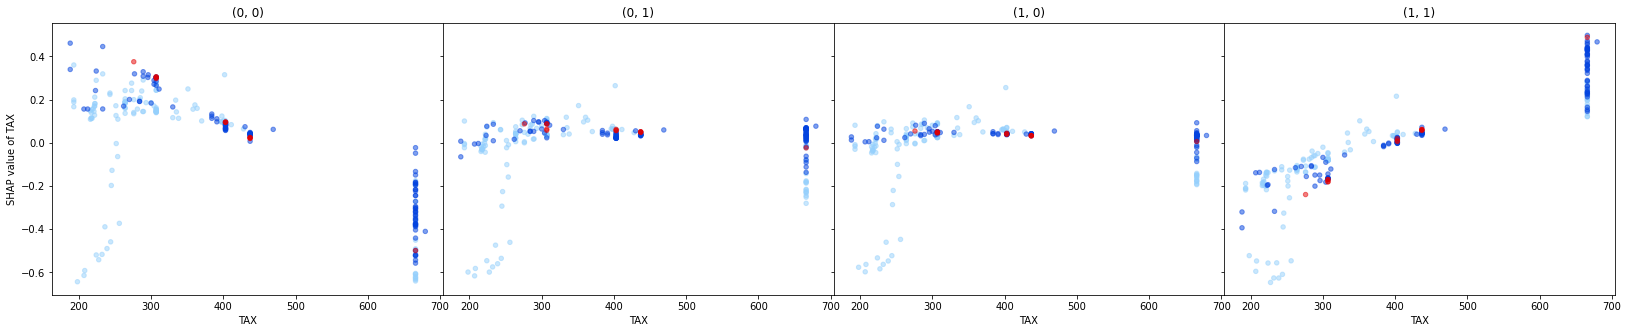

5.614908882373981 <= RM <= 6.319
[]


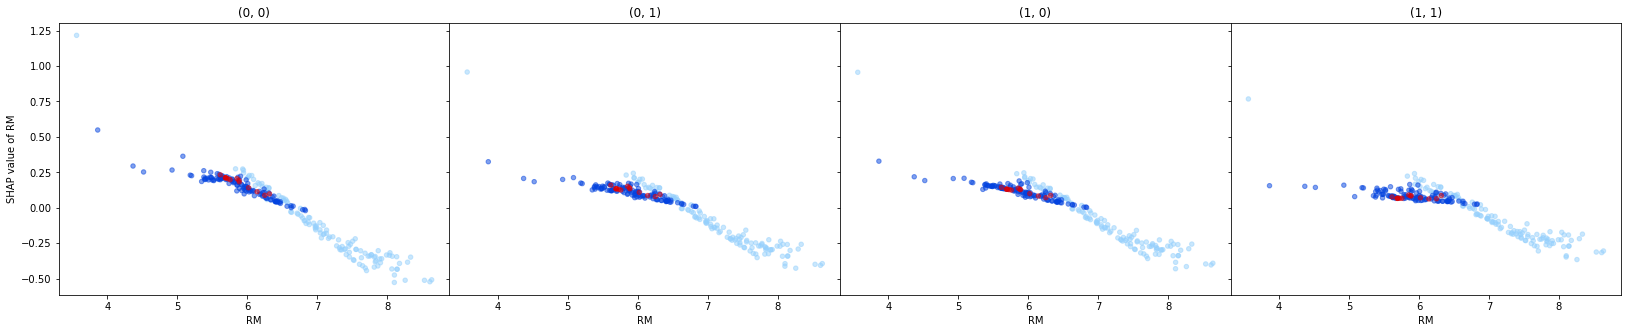

4.0 <= RAD
[]


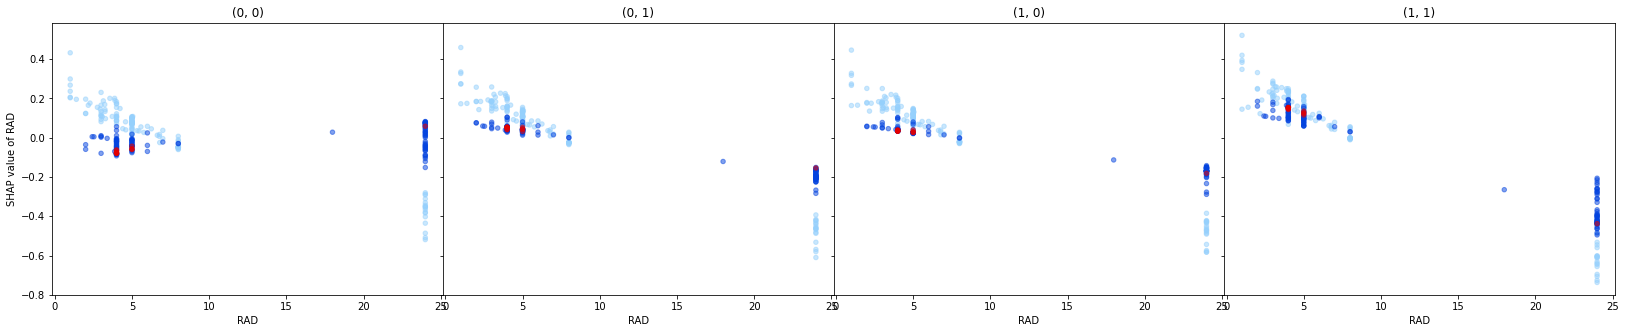

1.7883 <= DIS <= 4.44168999446776
[]


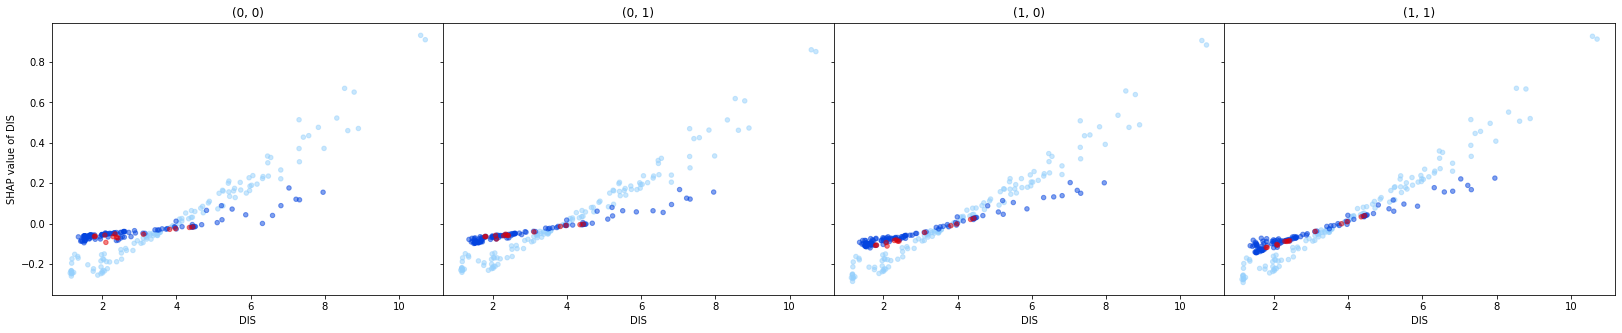

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}]


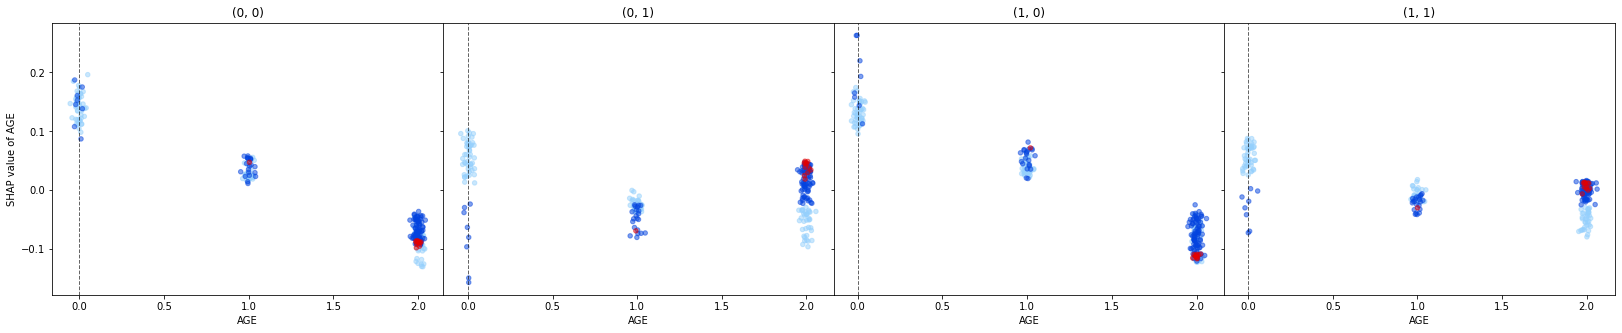

14.7 <= PTRATIO <= 21.2
[]


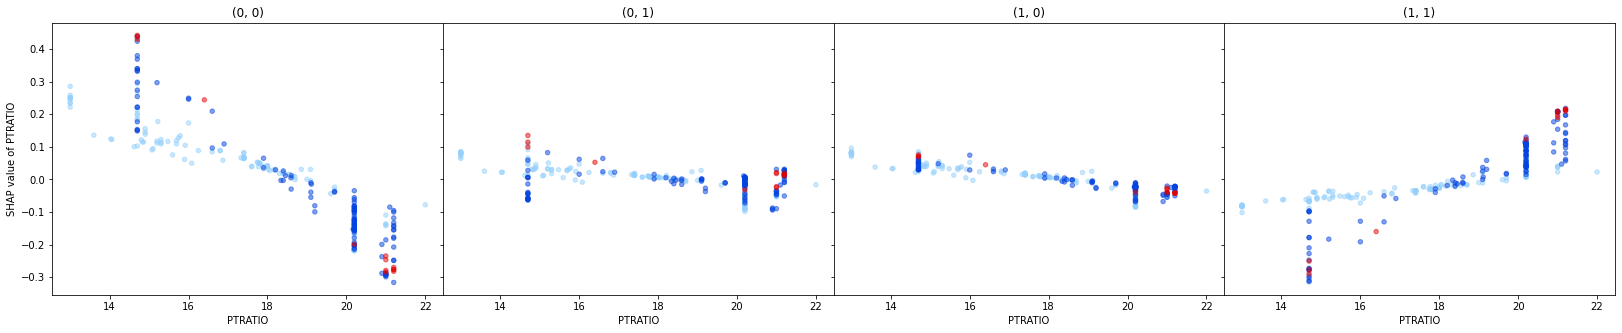

0.538 <= NOX <= 0.77
[]


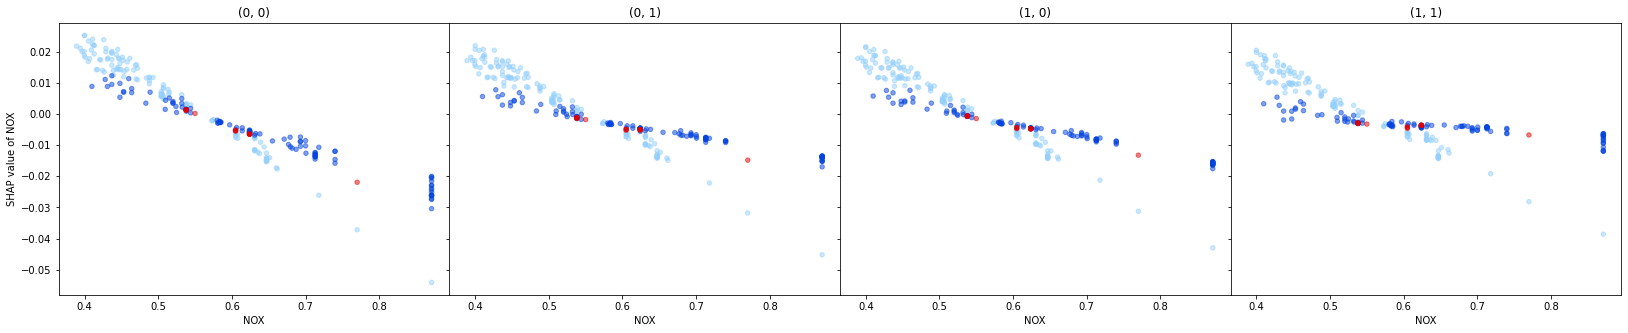

In [18]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

In [13]:
part = node.root.filter('10.24 < LSTAT <= 19.16')

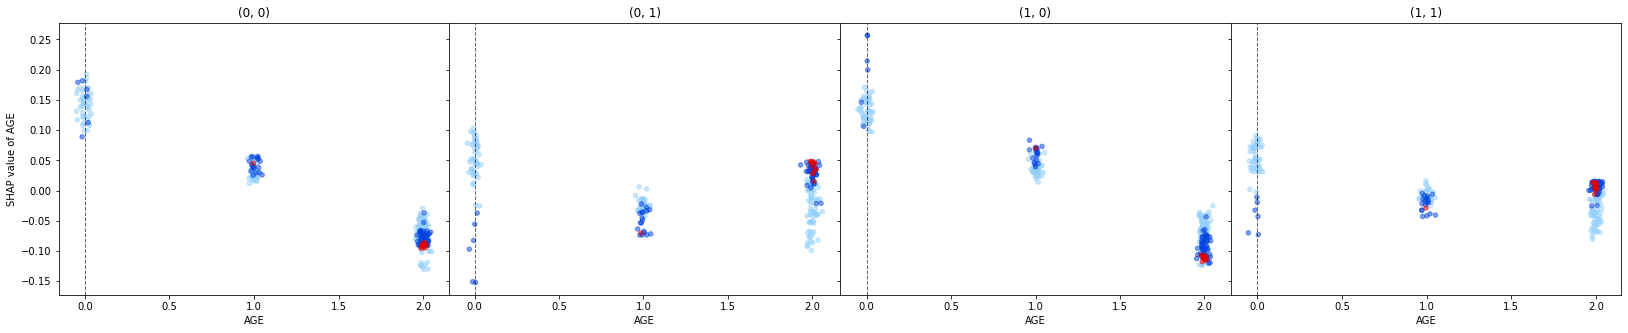

In [15]:
node.root.plot_feature_dependence('AGE', classes=classes, focus=part)

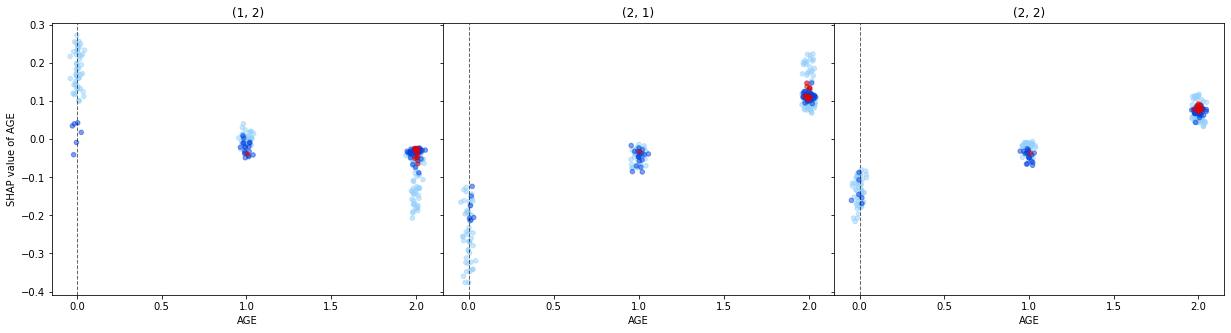

In [19]:
node.root.plot_feature_dependence('AGE', classes=['(1, 2)', '(2, 1)', '(2, 2)'], focus=part)

in this LSTAT range, high AGE increases the outcome of (2,1), (2,2) and (0,1). So why are some classified (0,1)? LSTAT has a much bigger negative influence in this range, thus preventing the first two labels and enforcing the third.

In [23]:
pd.Series(part.shap_values[:, 'LSTAT'].values.mean(0), index=comparer.class_names)

(0, 0)    1.539900
(0, 1)    1.108244
(0, 2)    0.086216
(1, 0)    1.016502
(1, 1)    0.598990
(1, 2)   -0.490618
(2, 0)   -0.057629
(2, 1)   -0.576330
(2, 2)   -1.683830
dtype: float64

In [24]:
node

L

### Node 1 (LLRL)

In [25]:
path = [node]
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LLRL,
 (0, 0)    21
 (0, 1)     6
 dtype: int64,
 5.341097868036927)

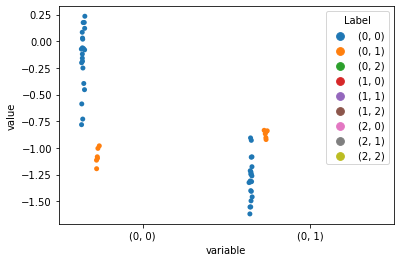

In [29]:
node.plot_outcomes(['(0, 0)', '(0, 1)'])

In [46]:
node.rule_from_counterfactuals()[0]

'10.24 < LSTAT <= 19.16 and ZN <= 5.0 and CRIM <= 6.1 and AGE > 0.0'

17.19 <= LSTAT <= 18.72
[Lower CF: LSTAT == 14.9 --> {'(1, 1)': 6},
 Upper CF: LSTAT == 18.95 --> {'(0, 0)': 6}]


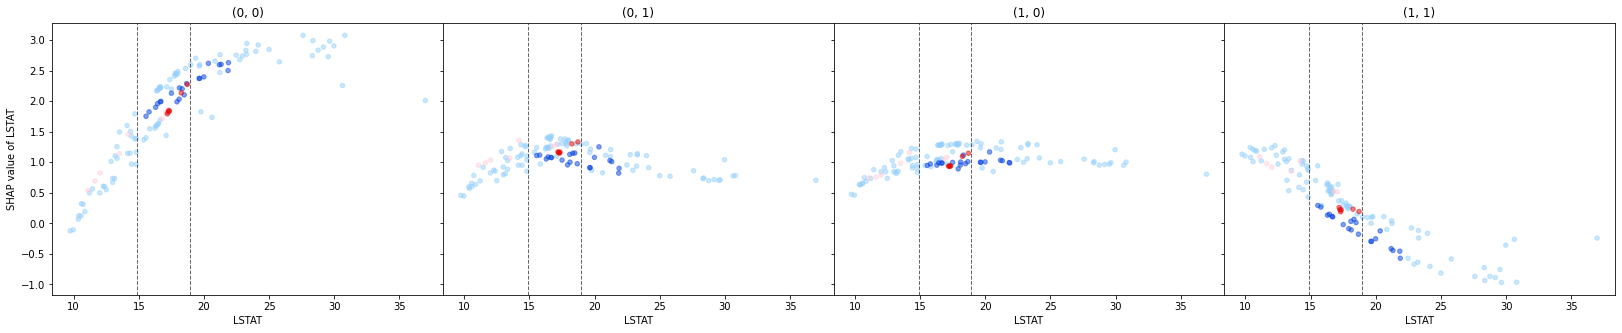

ZN == 0.0
[Upper CF: ZN == 6.0 --> {'(1, 1)': 6}]


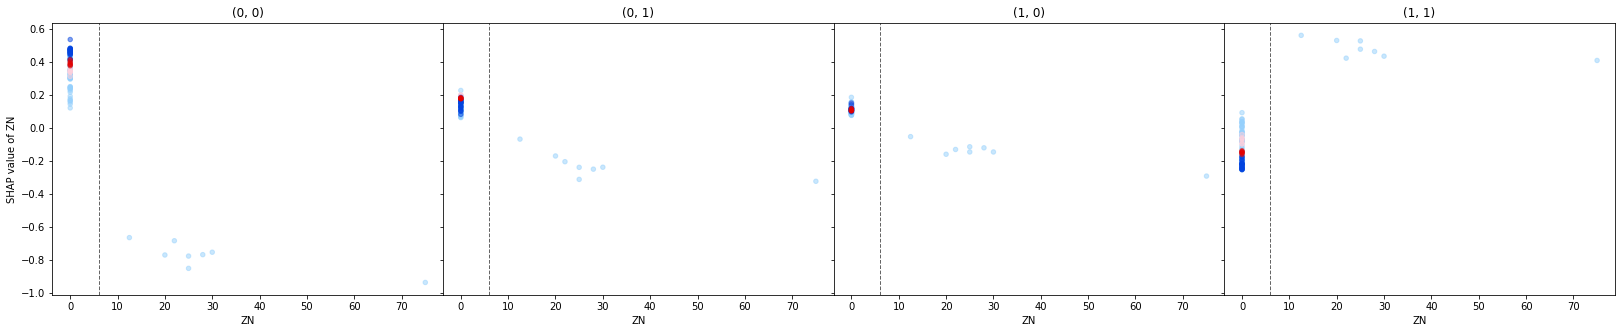

8.14 <= INDUS <= 21.89
[]


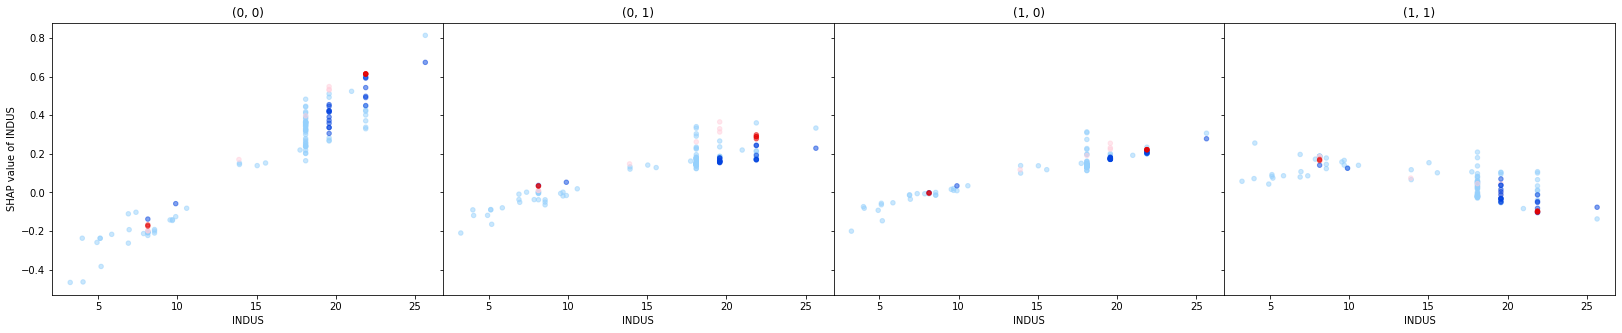

0.25915 <= CRIM <= 1.23247
[Upper CF: CRIM == 1.8 --> {'(0, 0)': 6}]


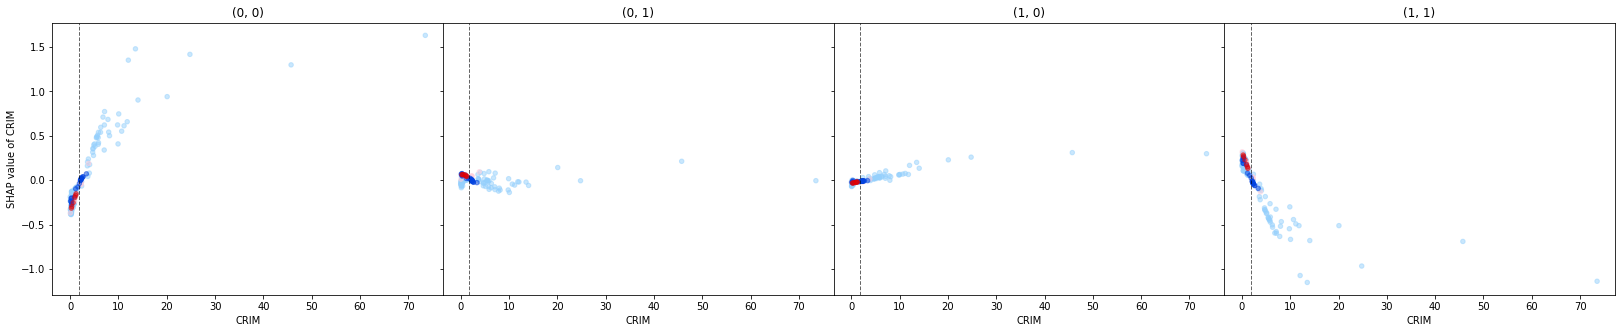

307.0 <= TAX <= 437.0
[Lower CF: TAX == 260.0 --> {'(0, 0)': 6},
 Upper CF: TAX == 619.0 --> {'(1, 1)': 6}]


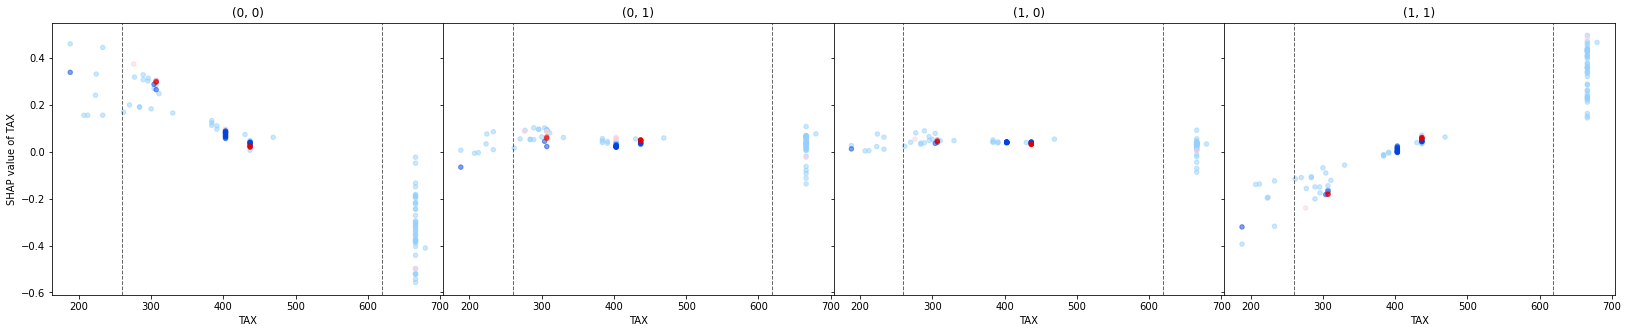

21.0 <= PTRATIO <= 21.2
[Lower CF: PTRATIO == 19.53 --> {'(0, 0)': 6}]


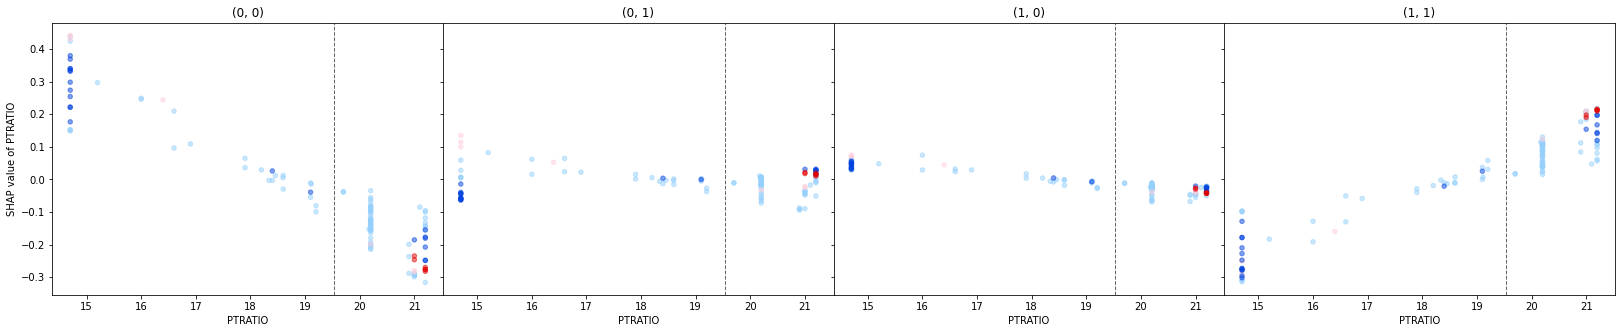

RAD == 4.0
[Upper CF: RAD == 12.41 --> {'(0, 0)': 6}]


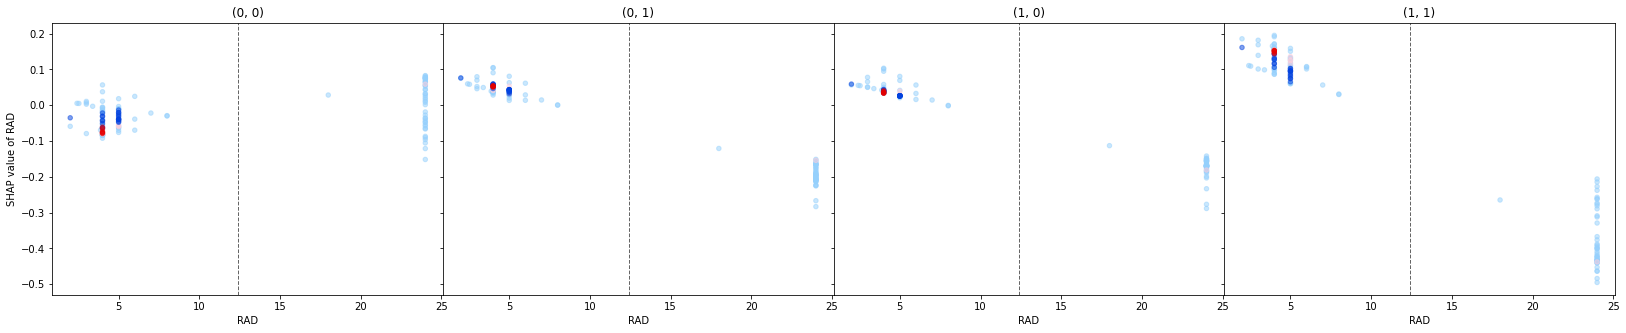

5.685294968854628 <= RM <= 6.142
[Lower CF: RM == 3.93 --> {'(0, 0)': 6}]


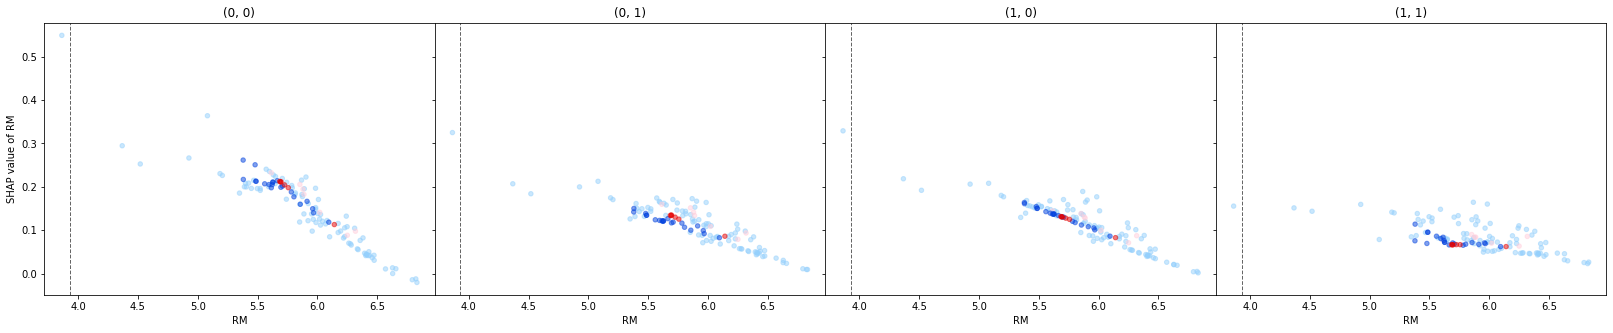

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(0, 0)': 6}]


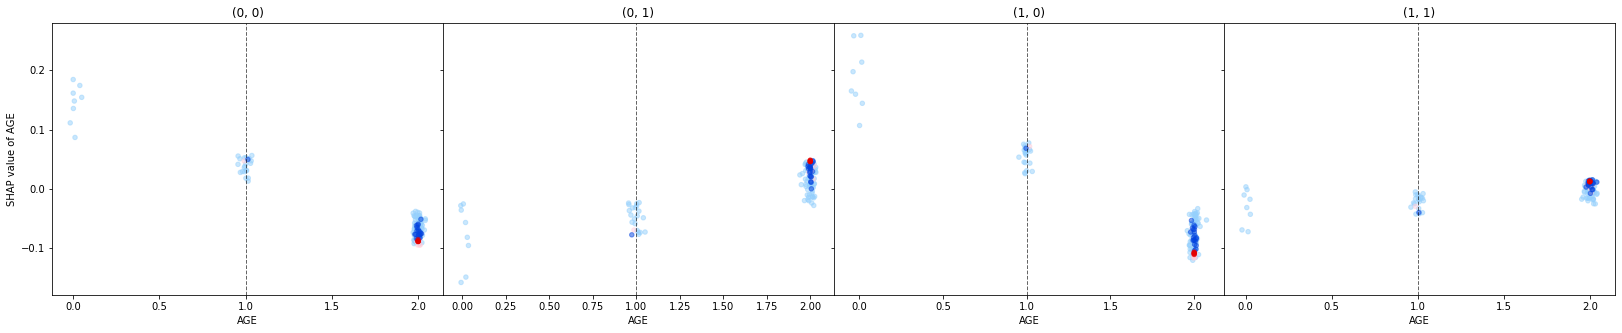

1.7883 <= DIS <= 3.9769
[]


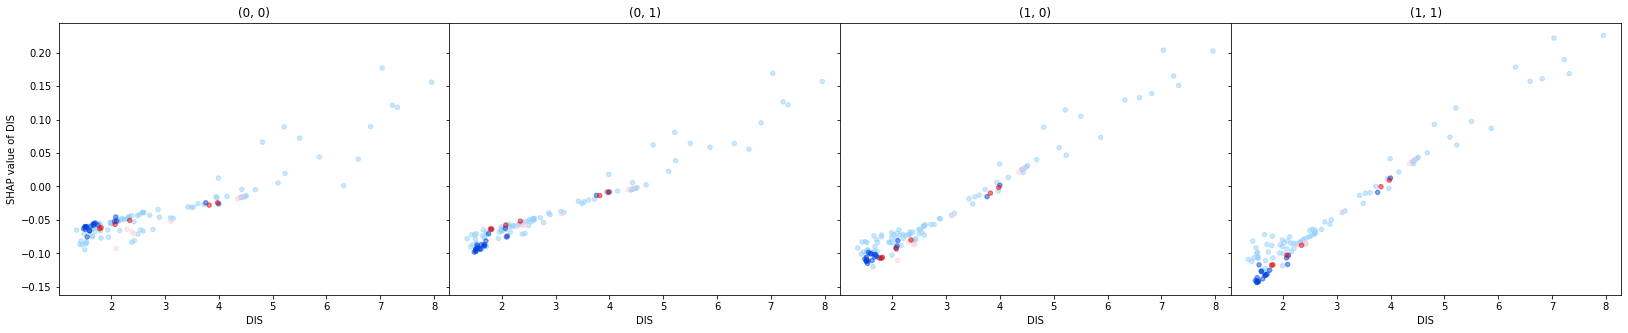

0.538 <= NOX <= 0.624
[]


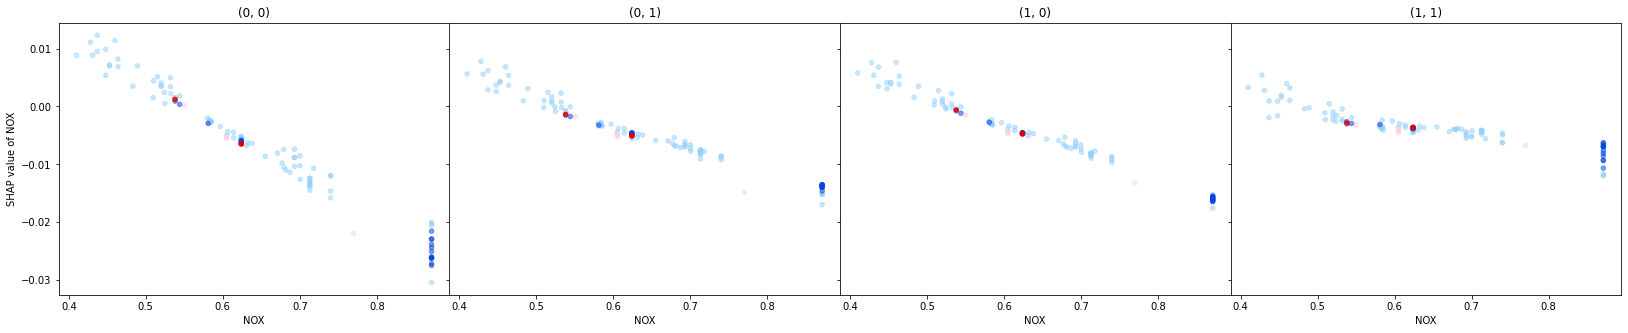

In [30]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)

INDUS == 21.89
[Lower CF: INDUS == 11.88 --> {'(1, 1)': 4}]


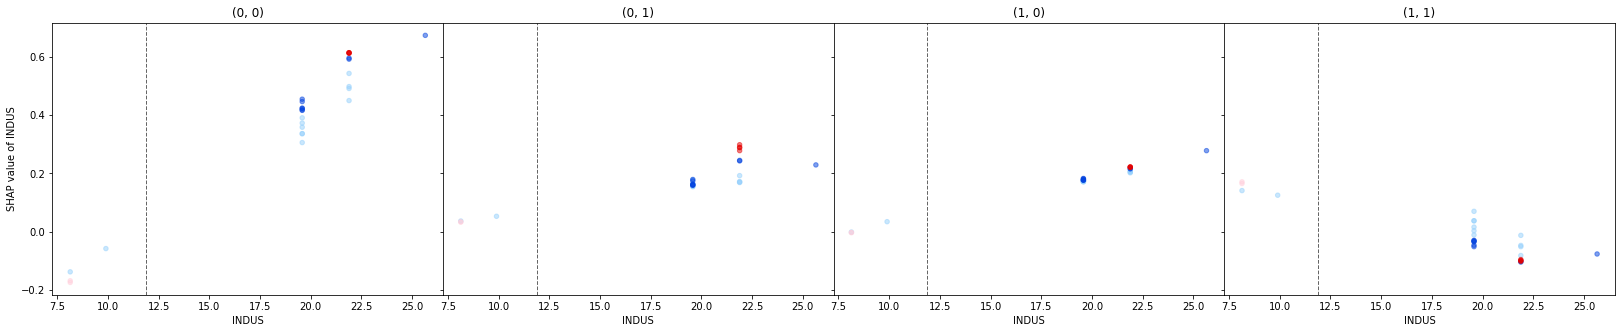

In [34]:
node.plot_feature_dependence('INDUS', focus=node.left, classes=classes, print_stats=True)

INDUS == 8.14
[Upper CF: INDUS == 10.64 --> {'(0, 0)': 2}]


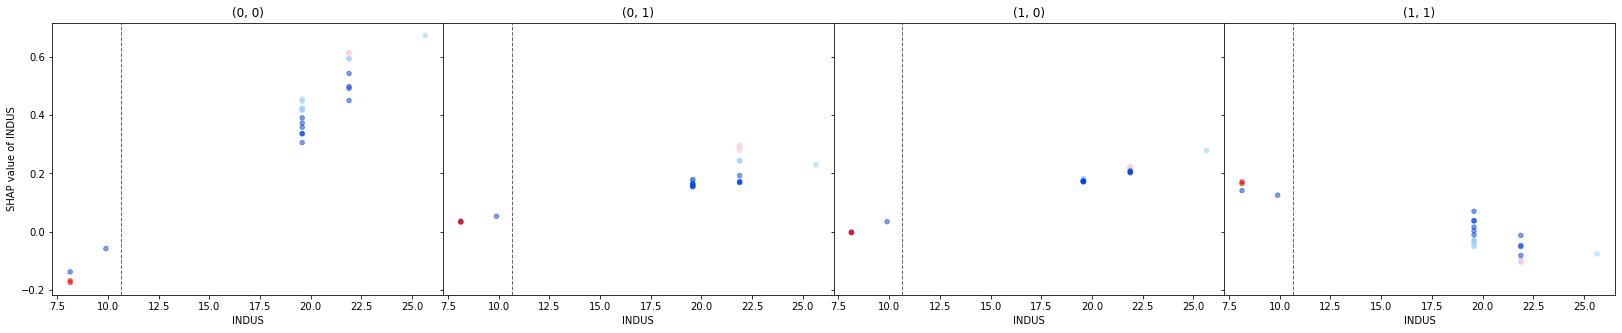

In [35]:
node.plot_feature_dependence('INDUS', focus=node.right, classes=classes, print_stats=True)

### Node 2 (LRRRR)

In [36]:
node = path[-1].right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRR,
 (1, 1)    16
 (0, 1)     7
 (0, 0)     4
 dtype: int64,
 10.371678074131047)

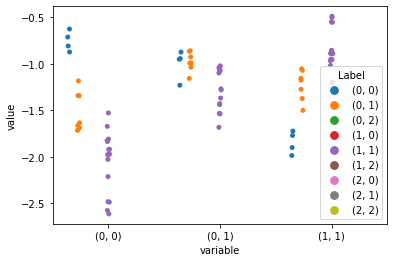

In [40]:
node.plot_outcomes(['(0, 0)', '(0, 1)', '(1, 1)'])

11.1 <= LSTAT <= 17.066695066513088
[Lower CF: LSTAT == 10.24 --> {'(1, 1)': 7},
 Upper CF: LSTAT == 19.17 --> {'(0, 0)': 7}]


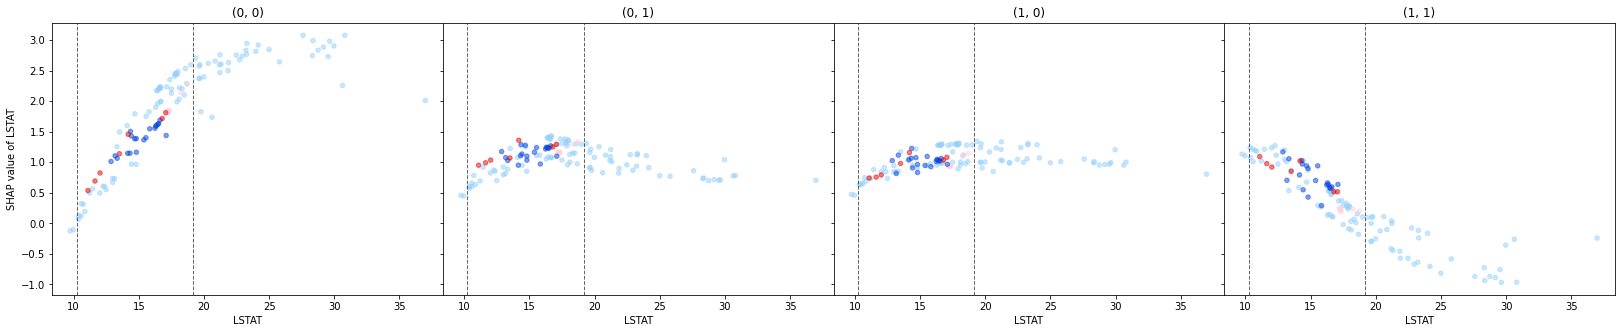

ZN == 0.0
[Upper CF: ZN == 5.0 --> {'(1, 1)': 7}]


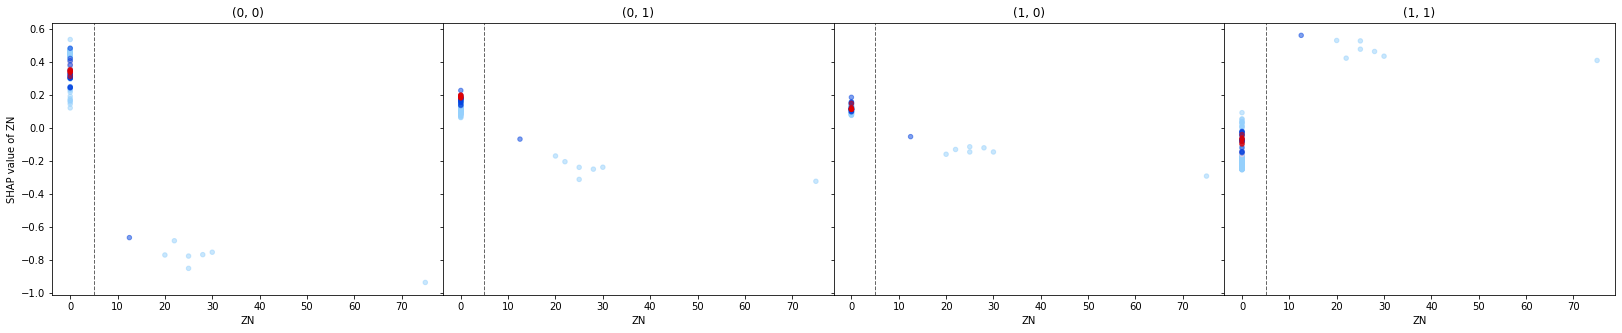

8.14 <= INDUS <= 19.58
[Lower CF: INDUS == 7.25 --> {'(1, 1)': 7}]


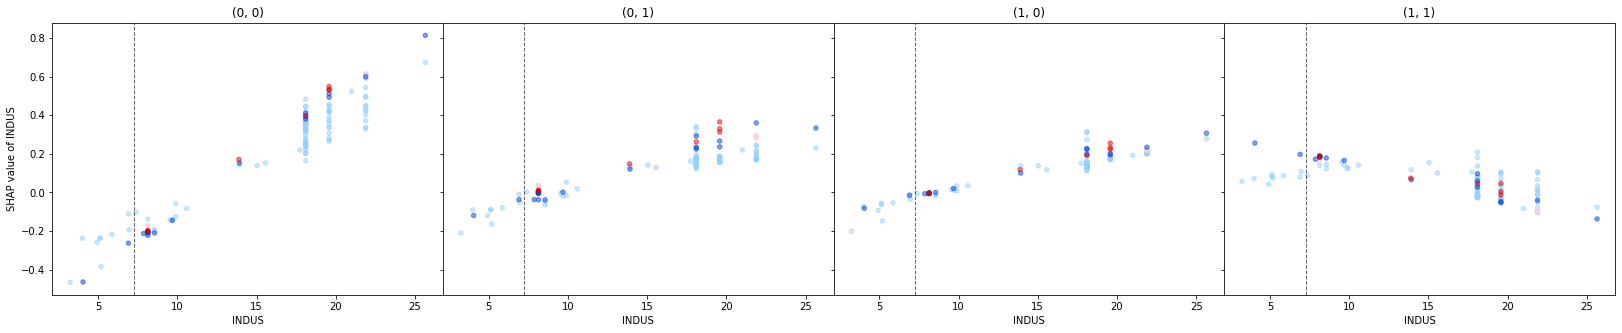

0.0456 <= CRIM <= 3.83684
[Upper CF: CRIM == 6.2 --> {'(0, 0)': 7}]


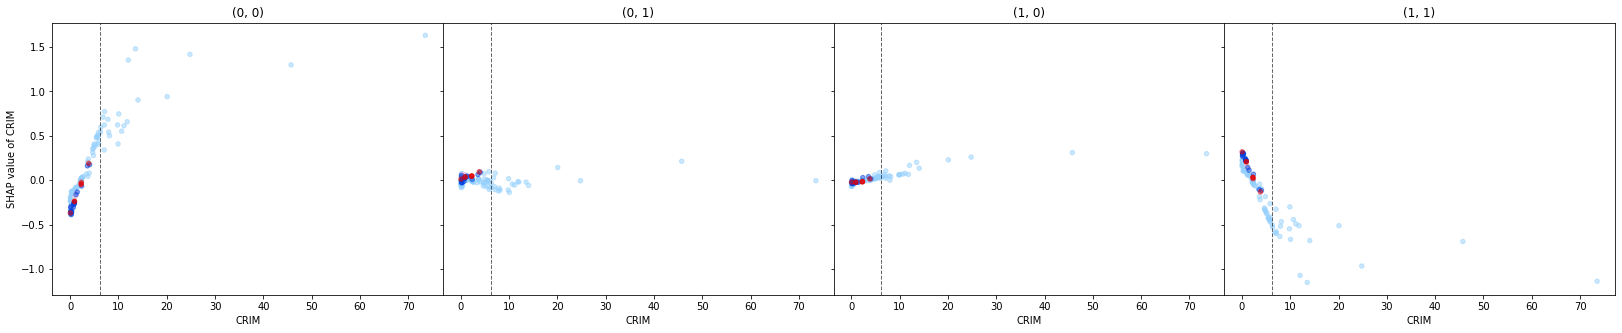

276.0 <= TAX <= 666.0
[]


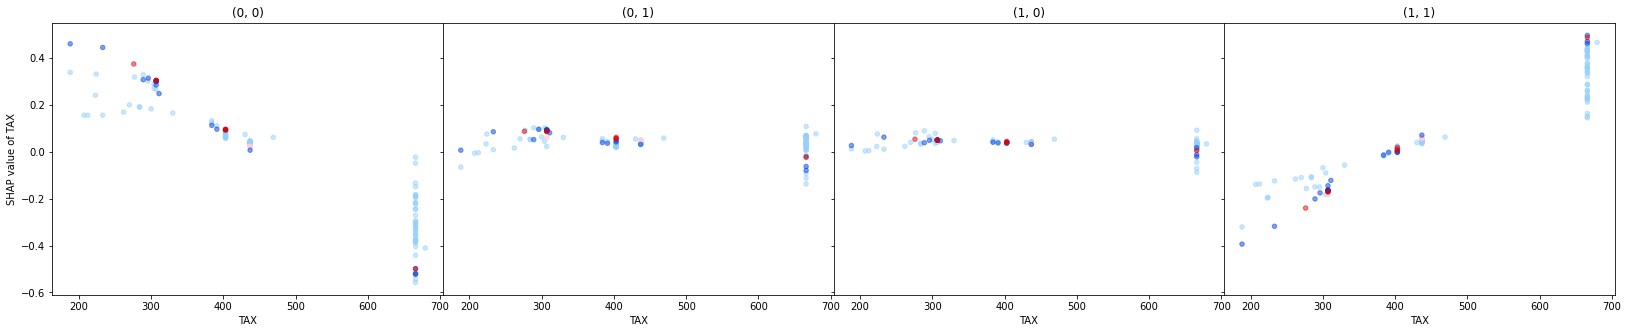

14.7 <= PTRATIO <= 21.0
[Upper CF: PTRATIO == 21.37 --> {'(1, 1)': 7}]


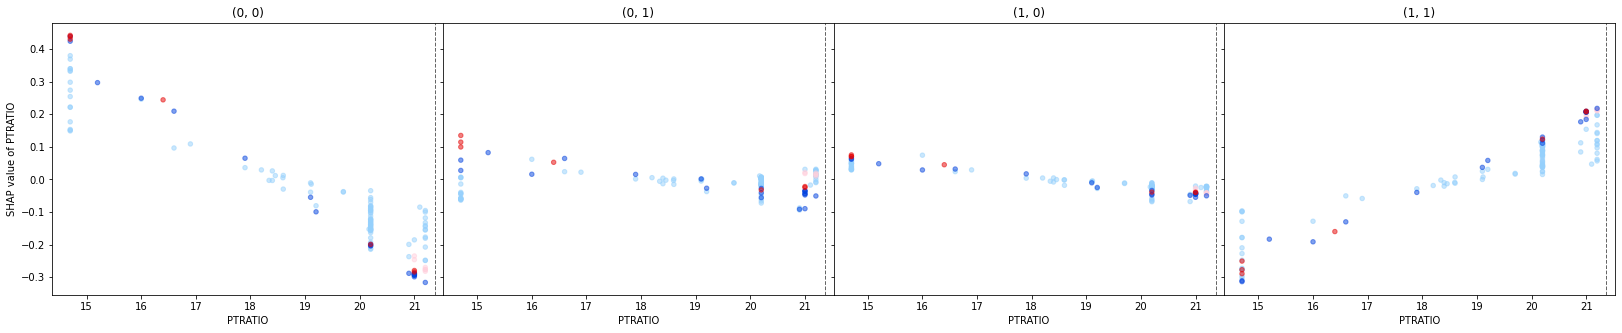

4.0 <= RAD
[]


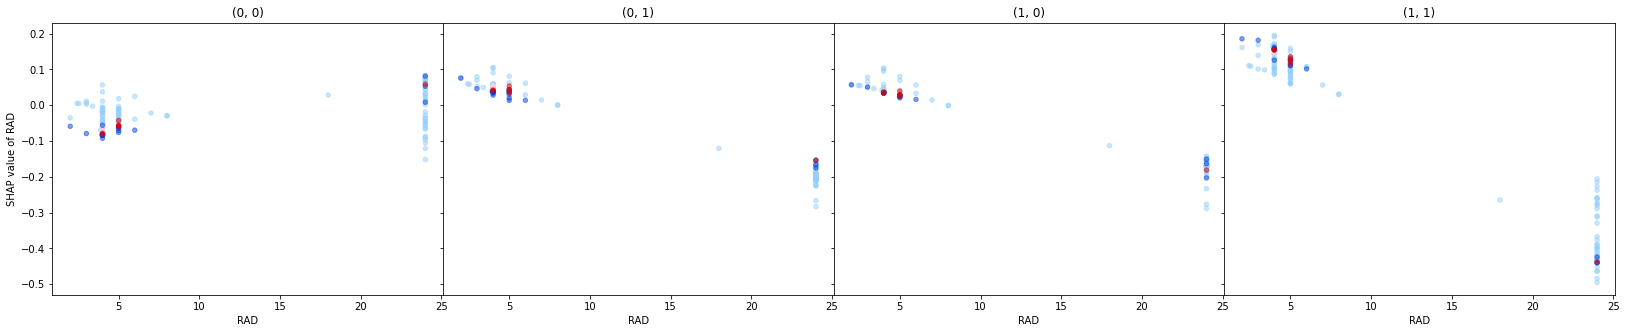

5.614908882373981 <= RM <= 6.319
[]


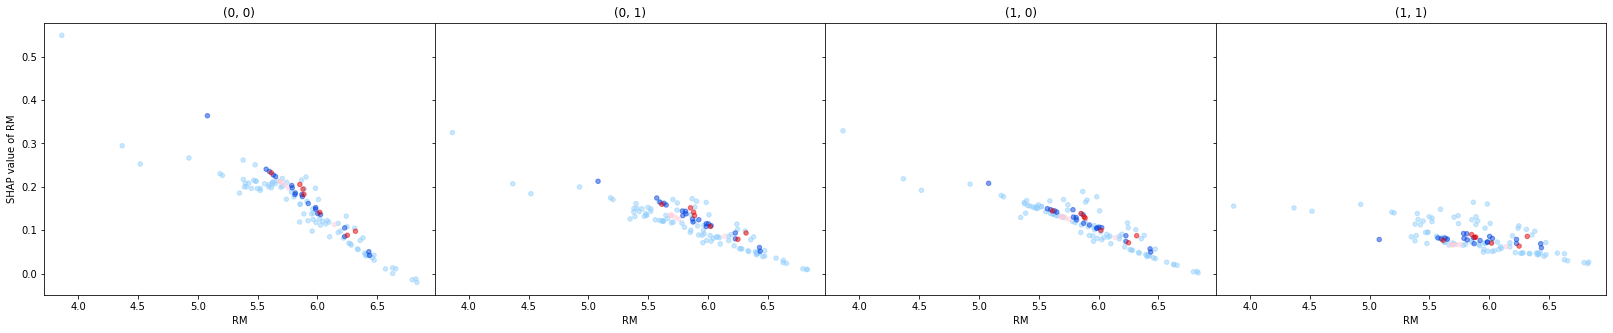

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 0)': 5, '(0, 0)': 2}]


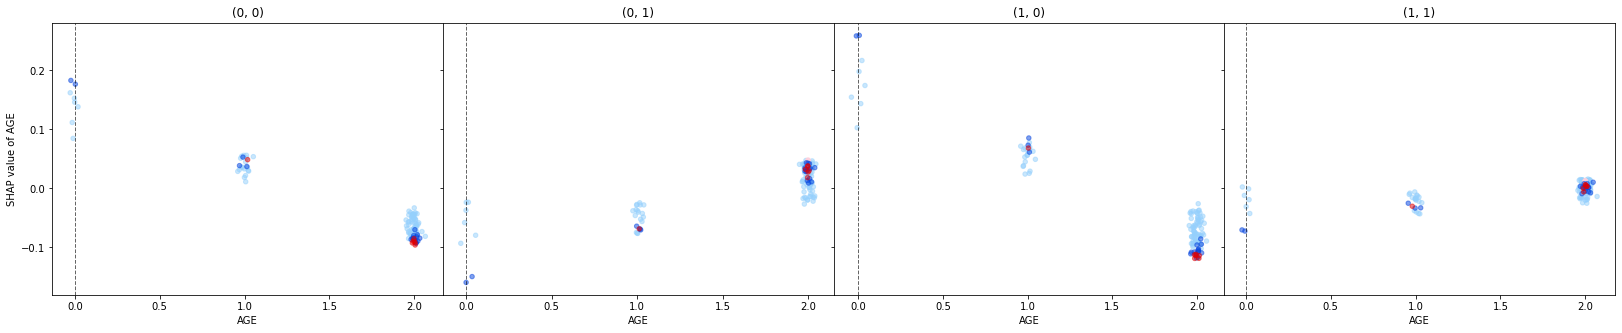

2.1 <= DIS <= 4.44168999446776
[]


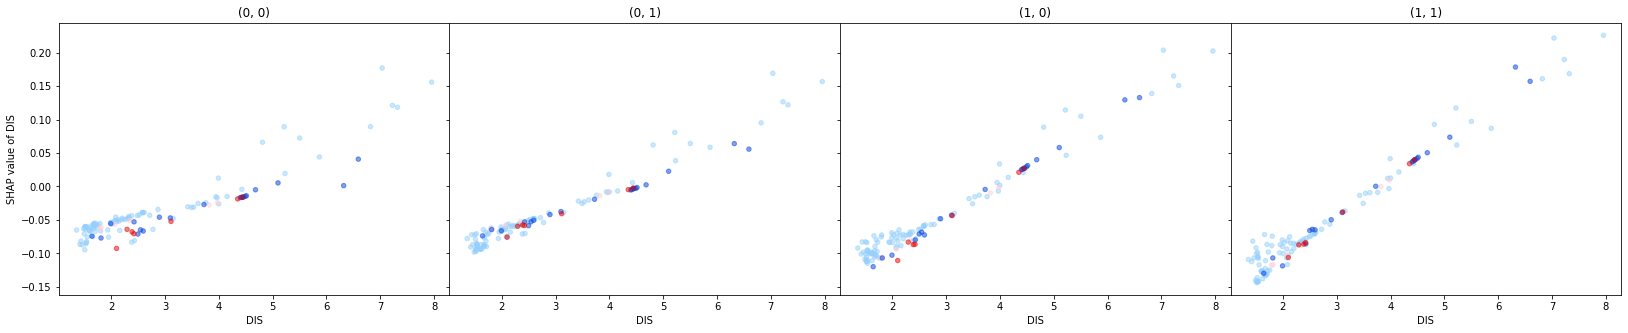

0.538 <= NOX <= 0.77
[]


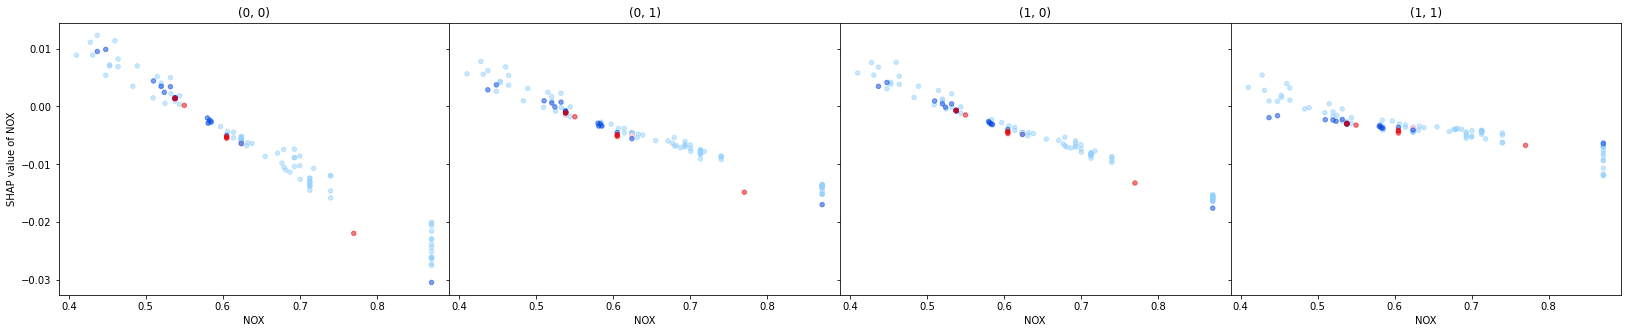

In [41]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)

In [44]:
node.rule_from_counterfactuals()[0]

'10.24 < LSTAT <= 19.16 and INDUS > 7.25 and ZN <= 4.0 and PTRATIO <= 21.36 and CRIM <= 6.1 and AGE > 0.0'

## (1,2)

In [2]:
node = load('(1, 2)')
node.class_counts, node.distance
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']

### Main Node (RRLLRL)

In [3]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRLLRLL,
 (1, 2)    1
 dtype: int64,
 0)

In [4]:
node = node.parent
node, node.class_counts, node.distance

(RRLLRL,
 (1, 2)    1
 (1, 1)    1
 dtype: int64,
 0.5854112780283152)

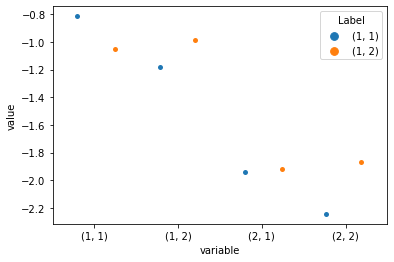

In [5]:
node.plot_outcomes(classes)

In [5]:
node.rule_from_counterfactuals()[0]

'4.51 < LSTAT <= 6.27 and AGE <= 0.0 and 1.9 < DIS <= 5.65 and INDUS <= 8.14 and CRIM <= 14.6 and 4.27 < RAD <= 12.72 and 6.2 < RM <= 7.74 and ZN <= 89.0 and PTRATIO > 17.34'

LSTAT == 6.15
[Lower CF: LSTAT == 4.51 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 6.28 --> {'(1, 1)': 1}]


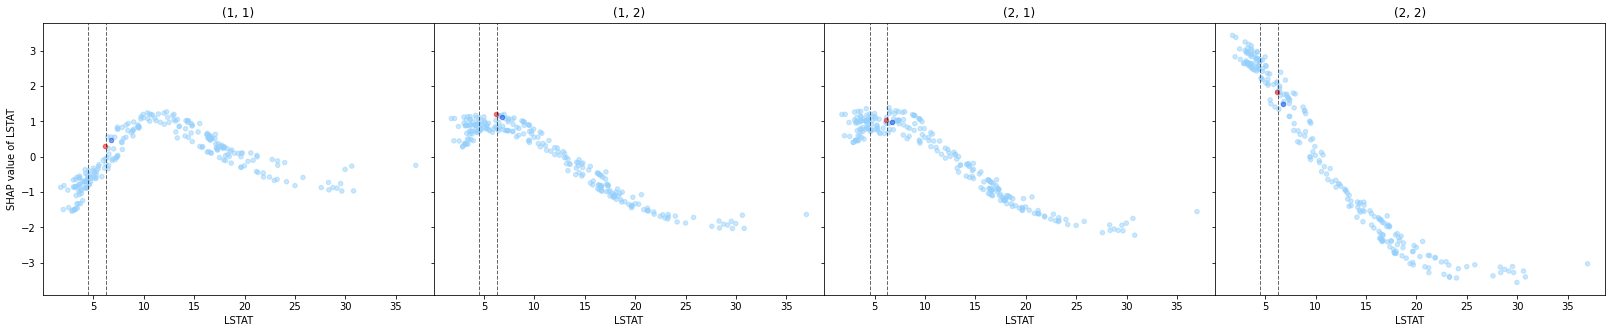

AGE == 0.0
[Upper CF: AGE == 1.0 --> {'(1, 1)': 1}]


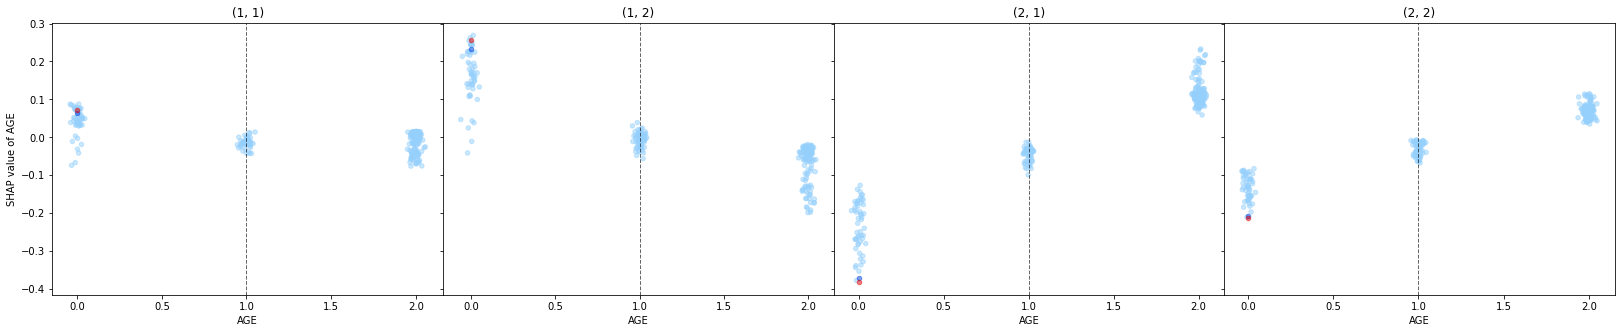

DIS == 5.4159
[Lower CF: DIS == 1.9 --> {'(2, 2)': 1},
 Upper CF: DIS == 5.66 --> {'(1, 1)': 1}]


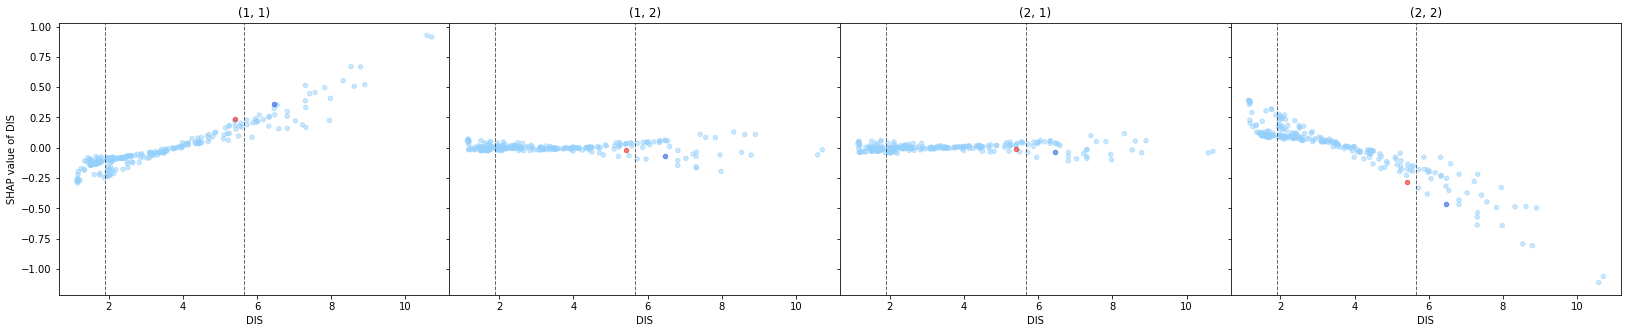

INDUS == 7.38
[Upper CF: INDUS == 8.15 --> {'(1, 1)': 1}]


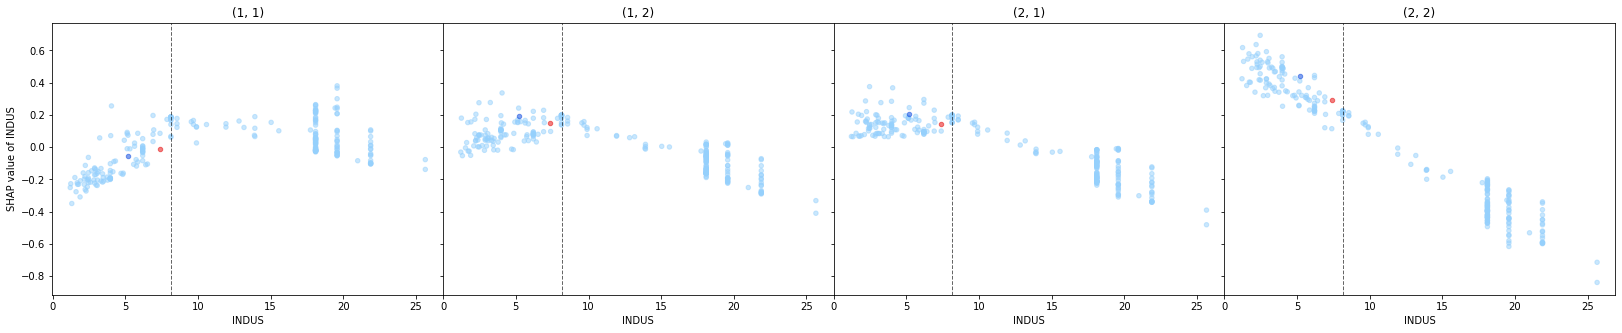

TAX == 287.0
[]


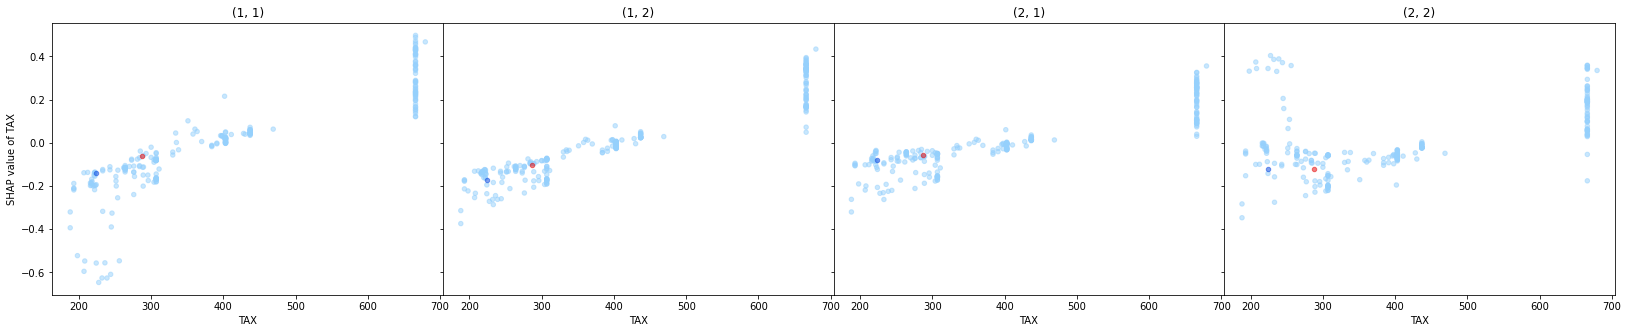

CRIM == 0.30347
[Upper CF: CRIM == 14.7 --> {'(0, 2)': 1}]


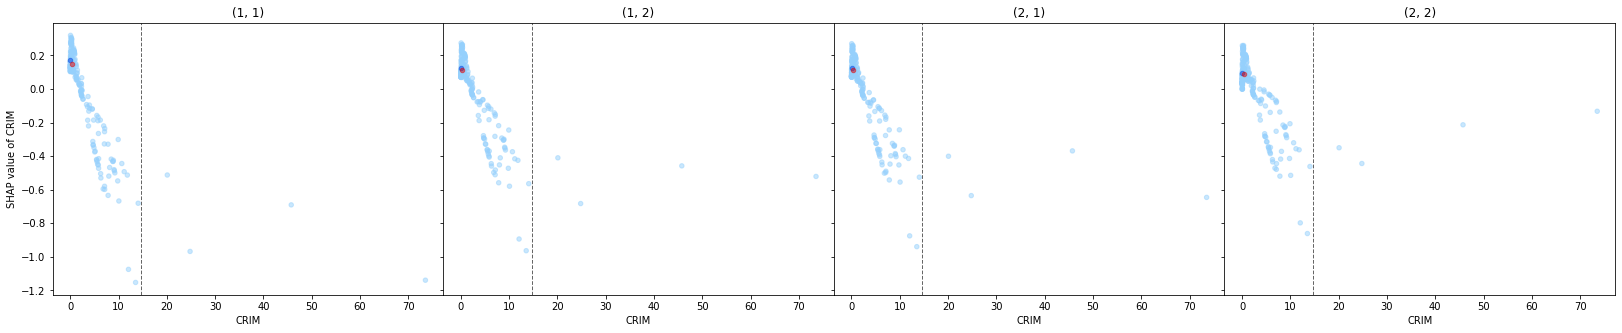

RAD == 5.0
[Lower CF: RAD == 4.27 --> {'(1, 1)': 1},
 Upper CF: RAD == 12.73 --> {'(2, 2)': 1}]


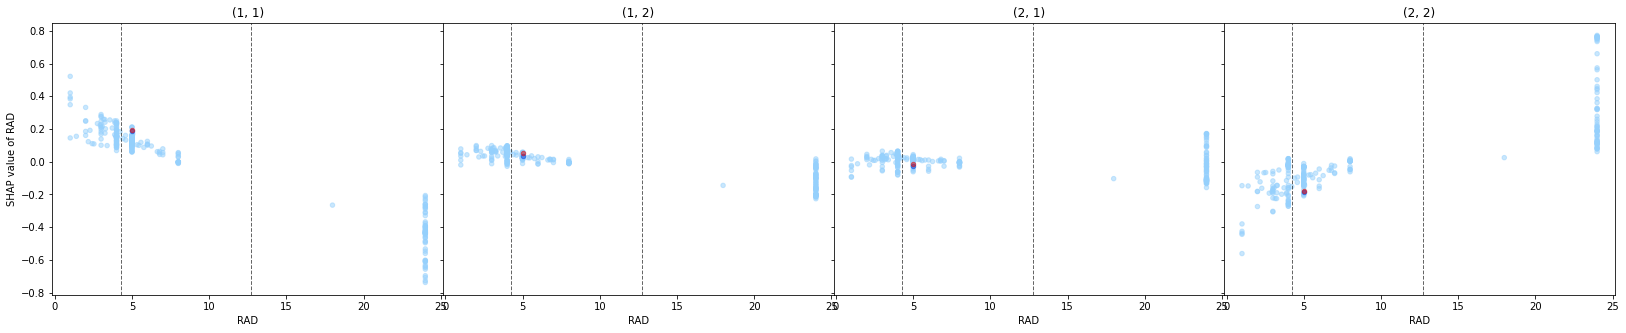

RM == 6.312
[Lower CF: RM == 6.2 --> {'(1, 1)': 1}, Upper CF: RM == 7.75 --> {'(2, 2)': 1}]


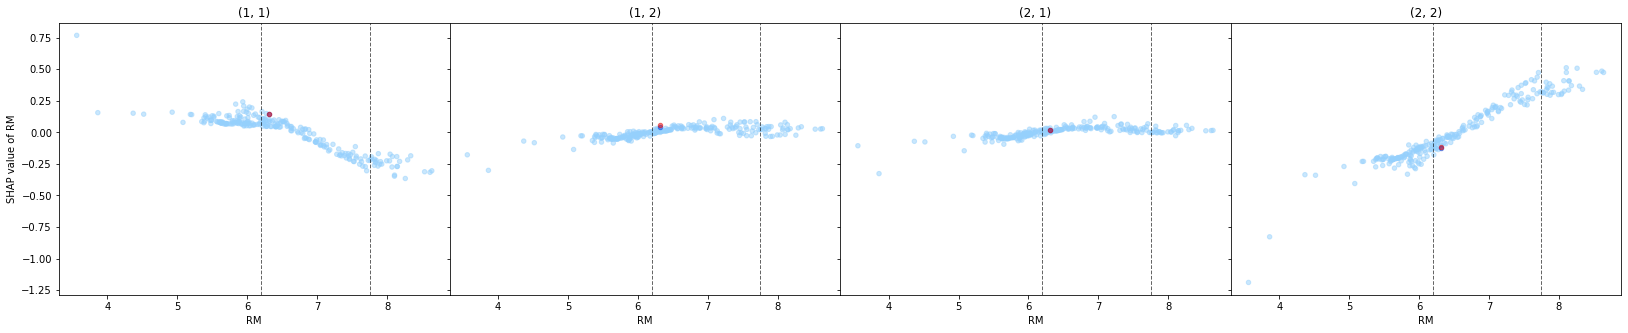

ZN == 0.0
[Upper CF: ZN == 90.0 --> {'(2, 2)': 1}]


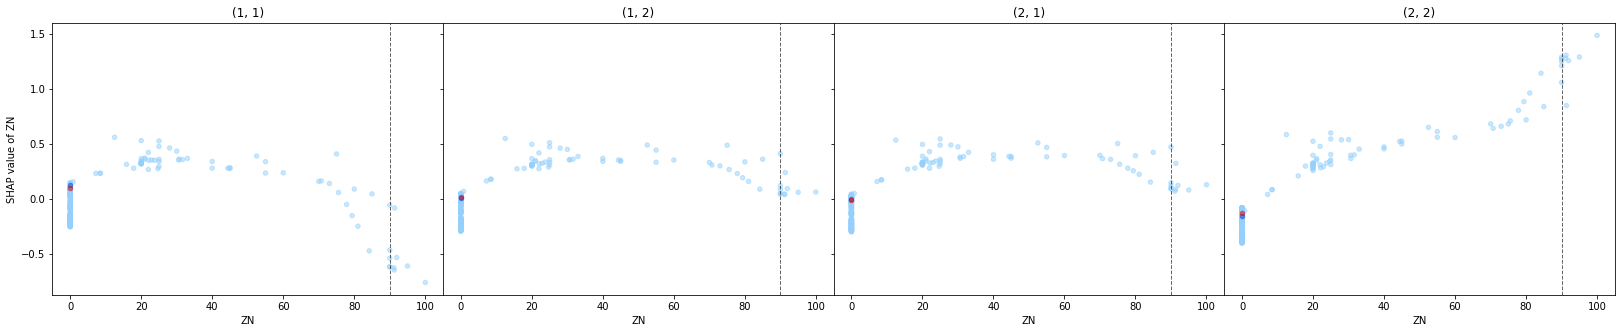

PTRATIO == 19.6
[Lower CF: PTRATIO == 17.34 --> {'(1, 1)': 1}]


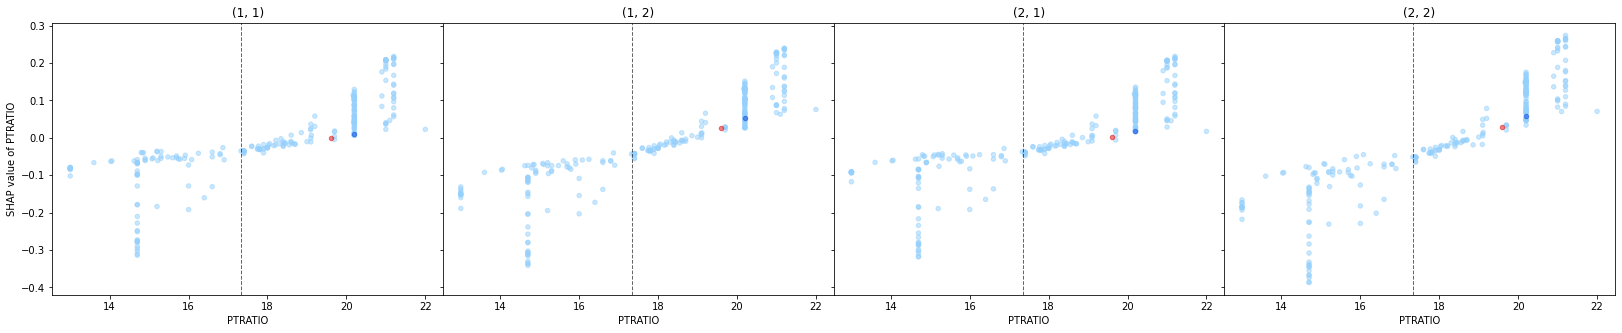

NOX == 0.493
[]


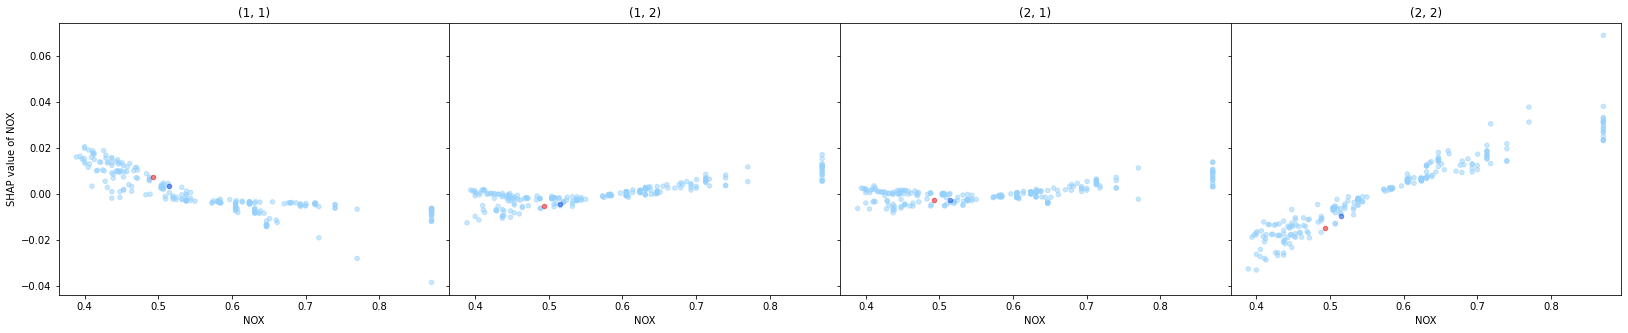

In [6]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

## (2,1)

In [7]:
node = load('(2, 1)')
node.class_counts, node.distance
classes = ['(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)']

### Main Node (RR)

In [8]:
node = node.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RR,
 (2, 2)    32
 (1, 1)    23
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 31.9493959231292)

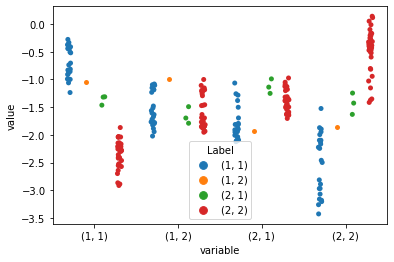

In [9]:
node.plot_outcomes(classes)

In [10]:
node.rule_from_counterfactuals()[0]

'5.97 < LSTAT <= 9.05 and INDUS <= 19.61 and ZN <= 81.0 and DIS <= 4.17 and CRIM <= 12.8 and AGE > 0.0 and RM <= 7.21'

6.48 <= LSTAT <= 8.93
[Lower CF: LSTAT == 5.97 --> {'(2, 2)': 3},
 Upper CF: LSTAT == 9.06 --> {'(1, 1)': 3}]


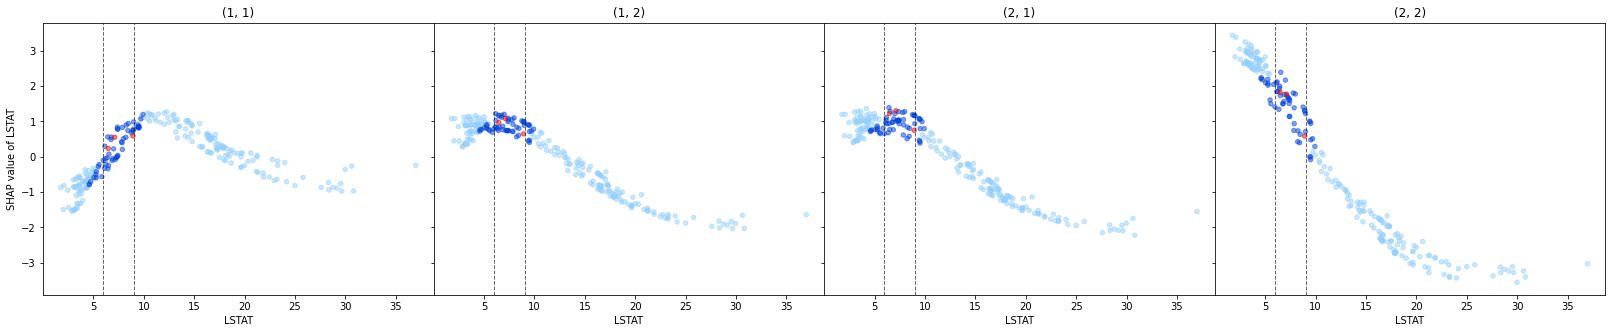

2.18 <= INDUS <= 18.1
[Upper CF: INDUS == 19.62 --> {'(1, 1)': 3}]


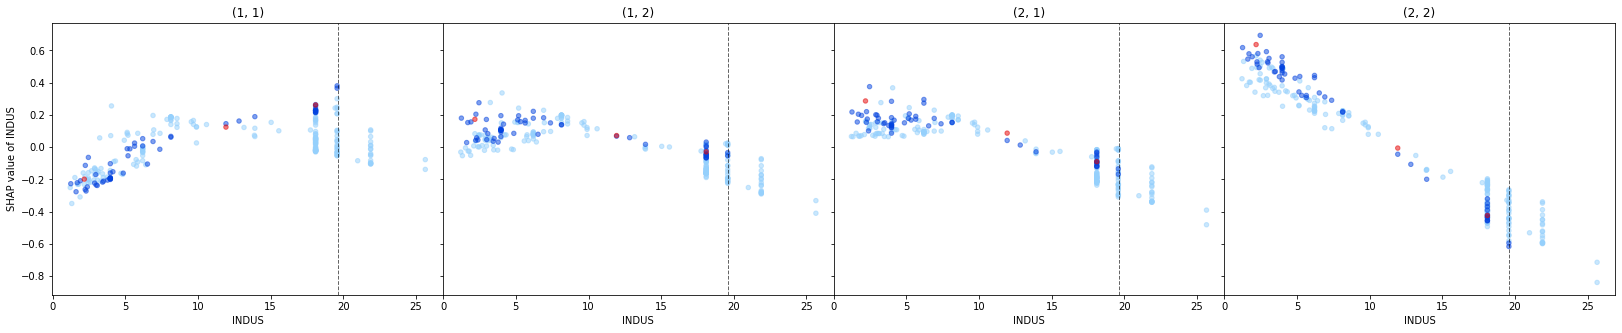

ZN <= 33.0
[Upper CF: ZN == 82.0 --> {'(2, 2)': 3}]


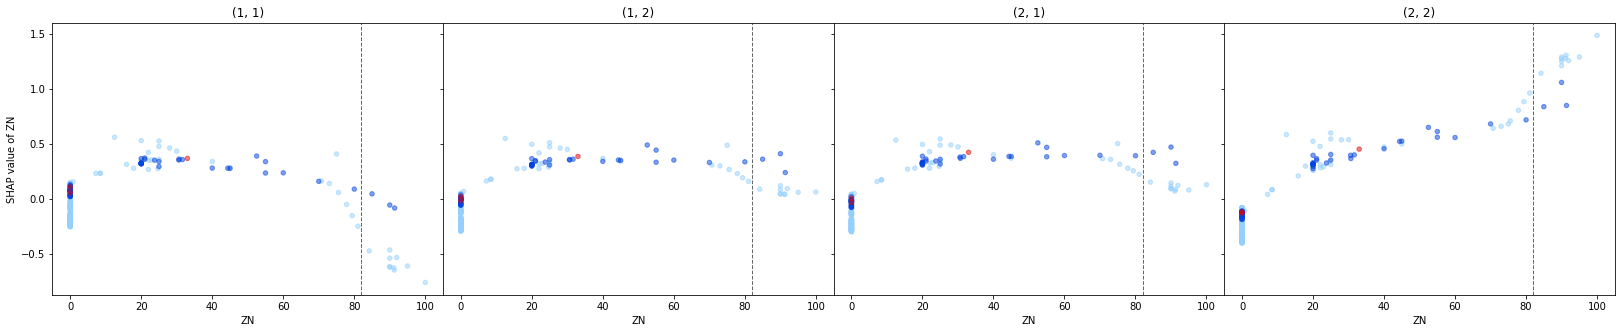

1.6132 <= DIS <= 3.37
[Upper CF: DIS == 4.18 --> {'(1, 1)': 3}]


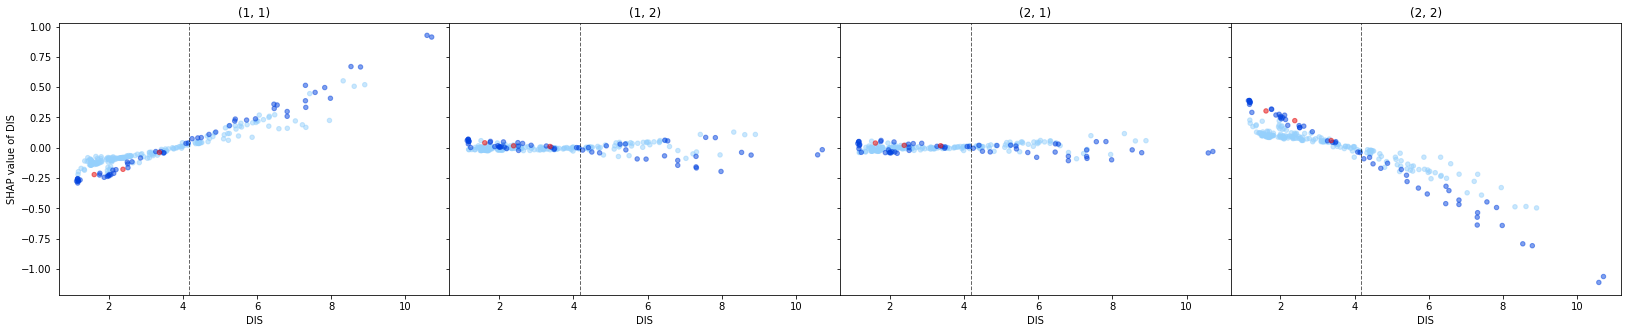

RAD
[]


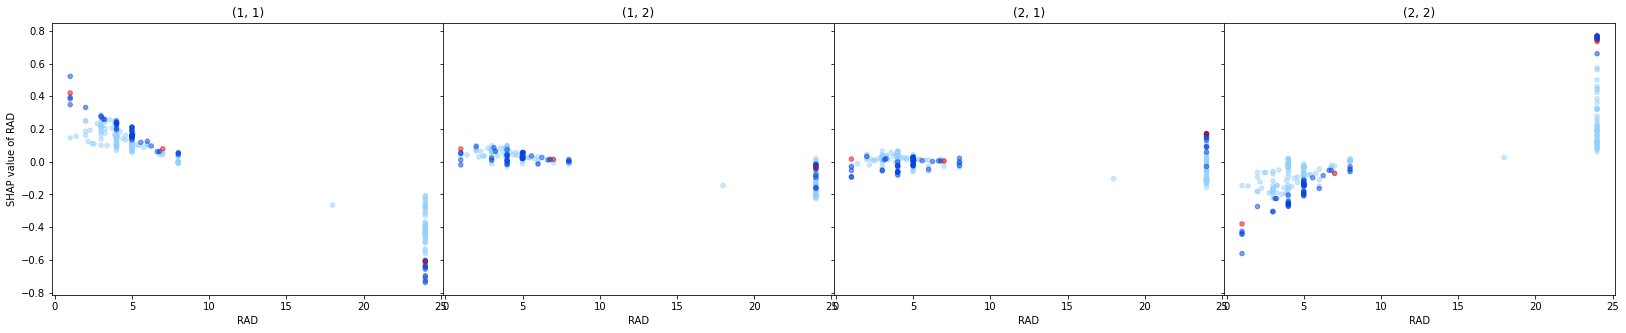

0.05479 <= CRIM <= 4.55587
[Upper CF: CRIM == 12.9 --> {'(2, 2)': 2, '(0, 1)': 1}]


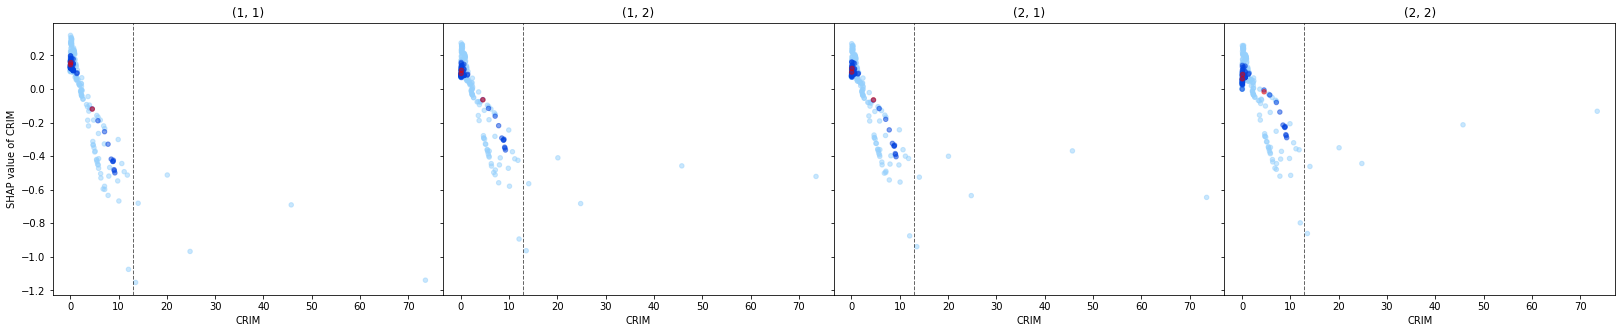

222.0 <= TAX <= 666.0
[]


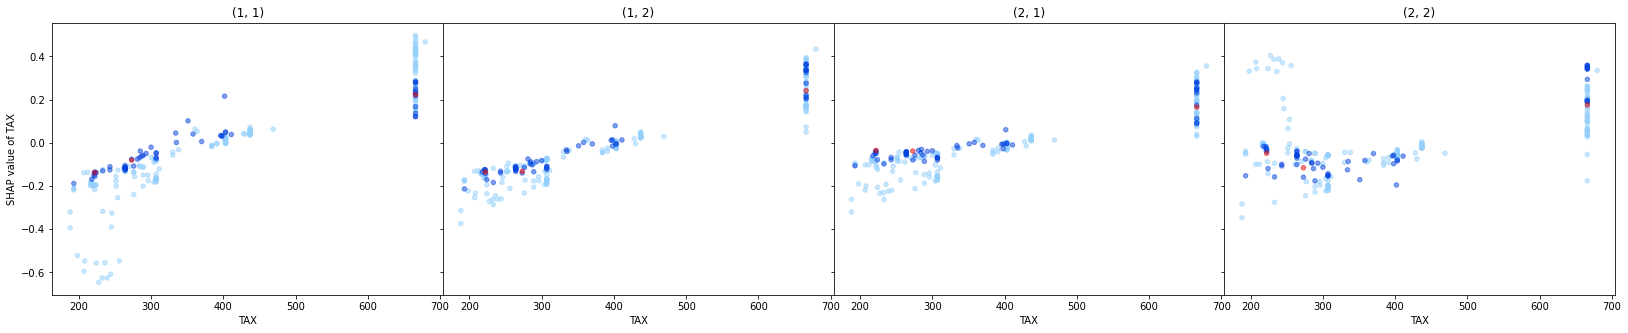

1.0 <= AGE
[Lower CF: AGE == 0.0 --> {'(1, 2)': 3}]


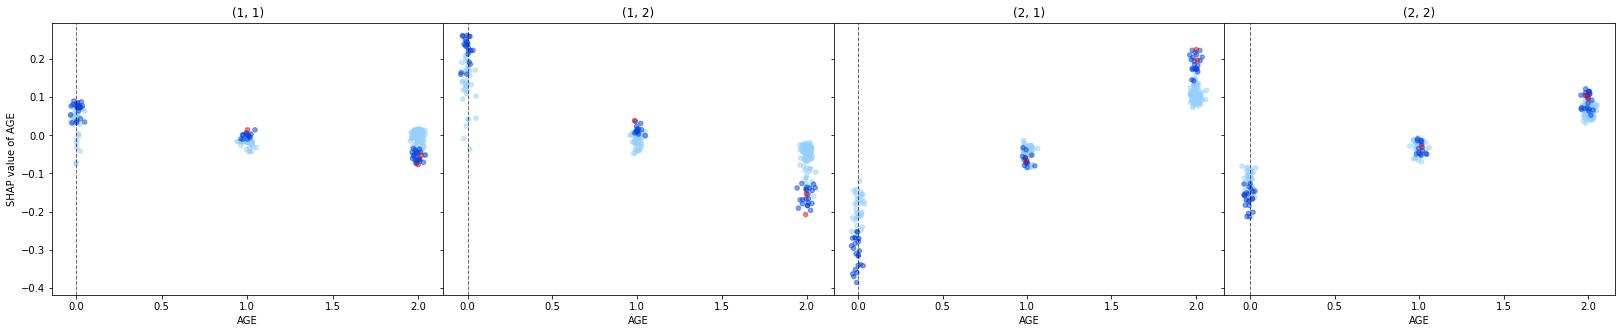

RM <= 6.794
[Upper CF: RM == 7.22 --> {'(2, 2)': 3}]


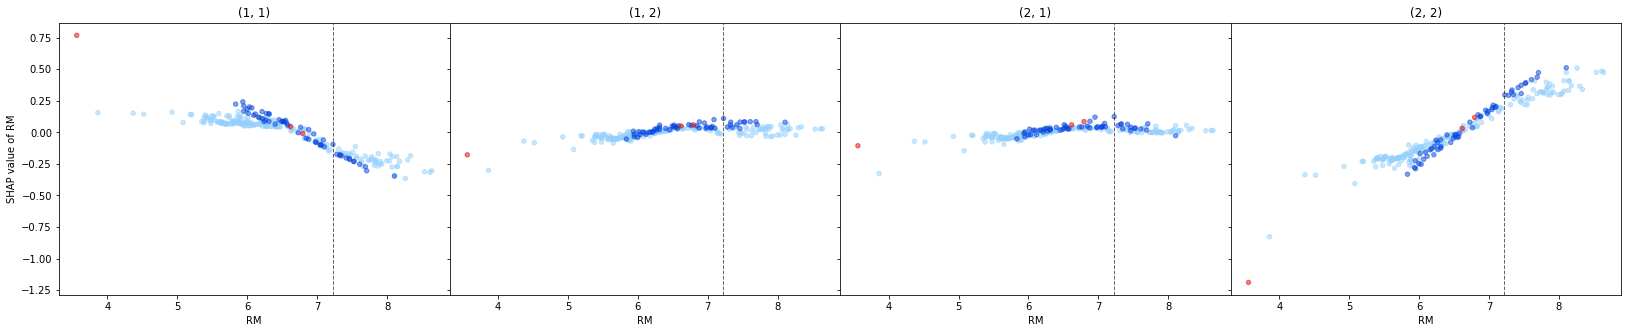

18.4 <= PTRATIO <= 21.0
[]


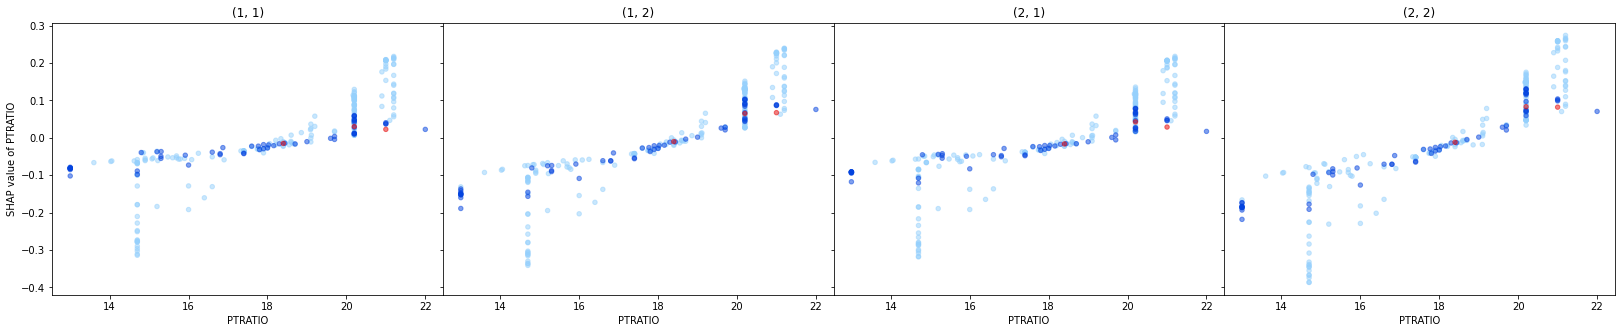

0.472 <= NOX <= 0.718
[]


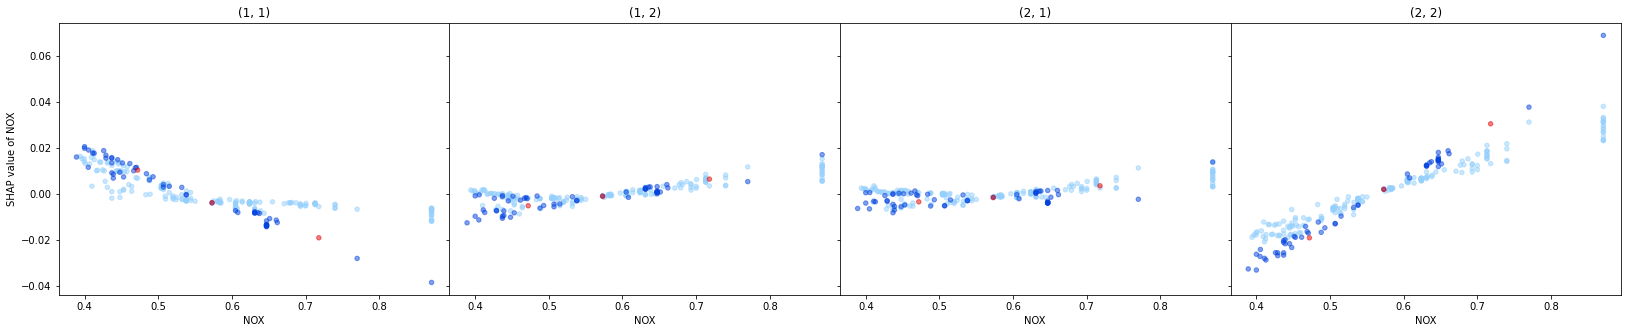

In [11]:
node.root.plot_feature_dependence(focus=node, classes=classes, print_stats=True)

### Node 1 (RRRLLL)

In [14]:
path = [node]
node = node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRRLLLR,
 (2, 1)    1
 dtype: int64,
 0)

In [15]:
node = node.parent
node, node.class_counts, node.distance

(RRRLLL,
 (1, 1)    1
 (2, 1)    1
 dtype: int64,
 0.7396148381437613)

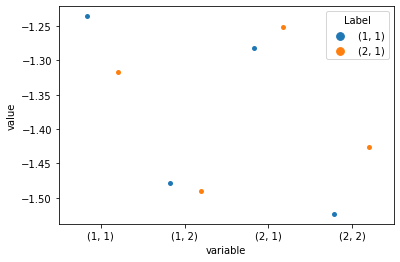

In [18]:
node.plot_outcomes(classes)

In [19]:
node.rule_from_counterfactuals()[0]

'8.55 < LSTAT <= 9.05 and 24.0 < ZN <= 61.0 and INDUS <= 2.85 and TAX <= 299.0 and CRIM <= 6.5 and 6.5 < RM <= 6.93 and 2.62 < DIS <= 3.64 and 6.39 < RAD <= 9.3 and AGE > 0.0'

LSTAT == 8.93
[Lower CF: LSTAT == 8.55 --> {'(2, 2)': 1},
 Upper CF: LSTAT == 9.06 --> {'(1, 1)': 1}]


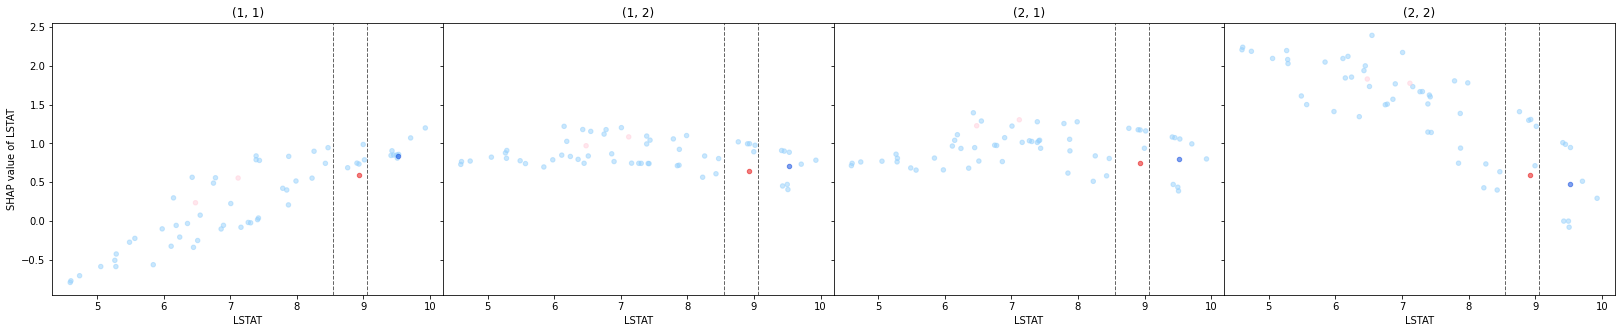

ZN == 33.0
[Lower CF: ZN == 24.0 --> {'(1, 1)': 1}, Upper CF: ZN == 62.0 --> {'(2, 2)': 1}]


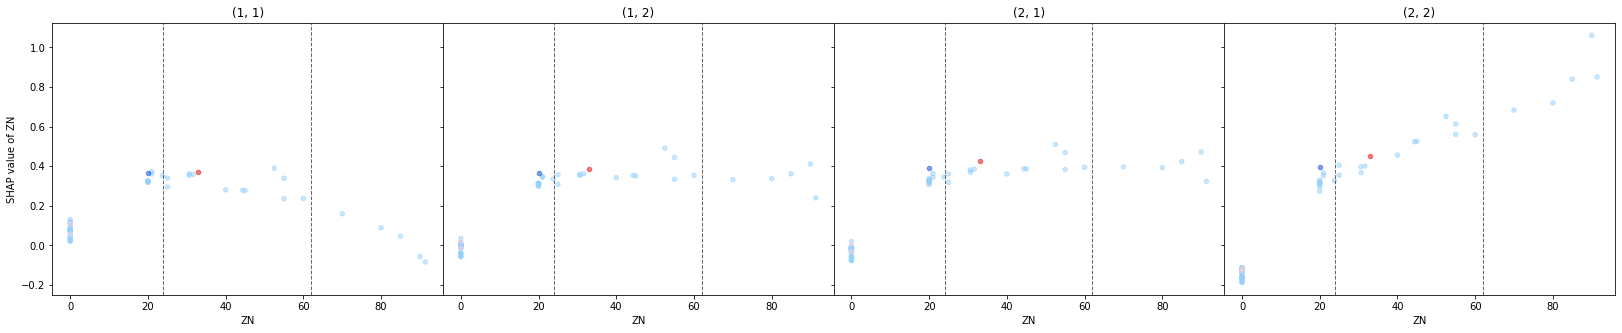

INDUS == 2.18
[Upper CF: INDUS == 2.86 --> {'(1, 1)': 1}]


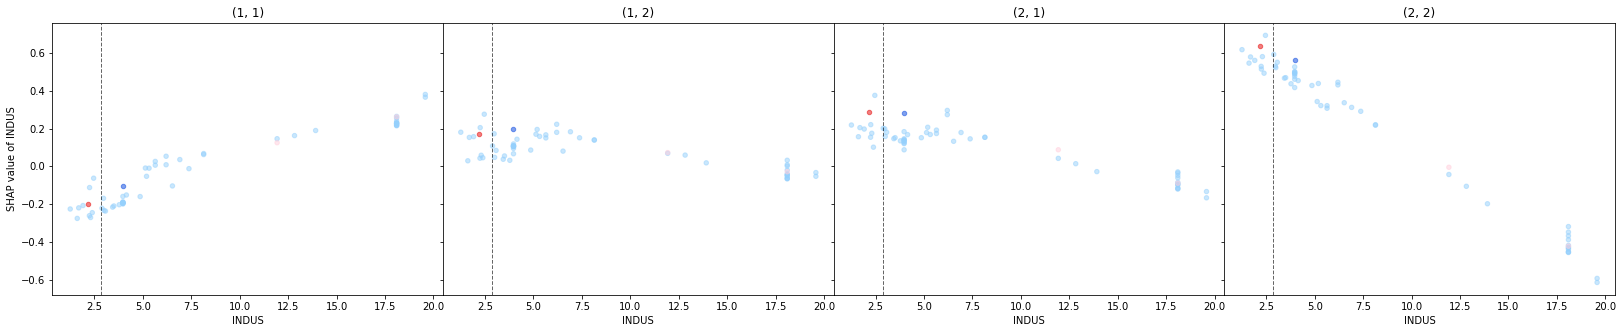

TAX == 222.0
[Upper CF: TAX == 300.0 --> {'(1, 1)': 1}]


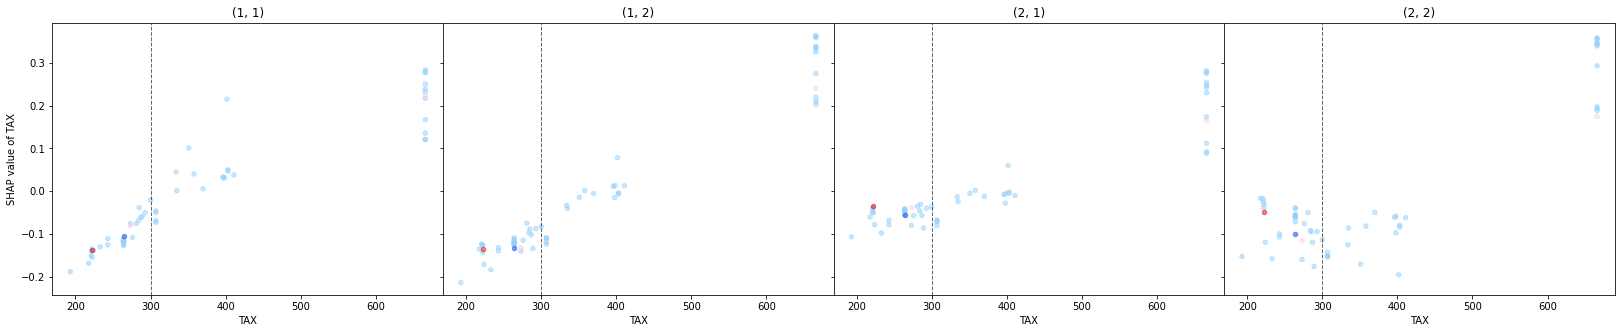

CRIM == 0.05479
[Upper CF: CRIM == 6.6 --> {'(2, 2)': 1}]


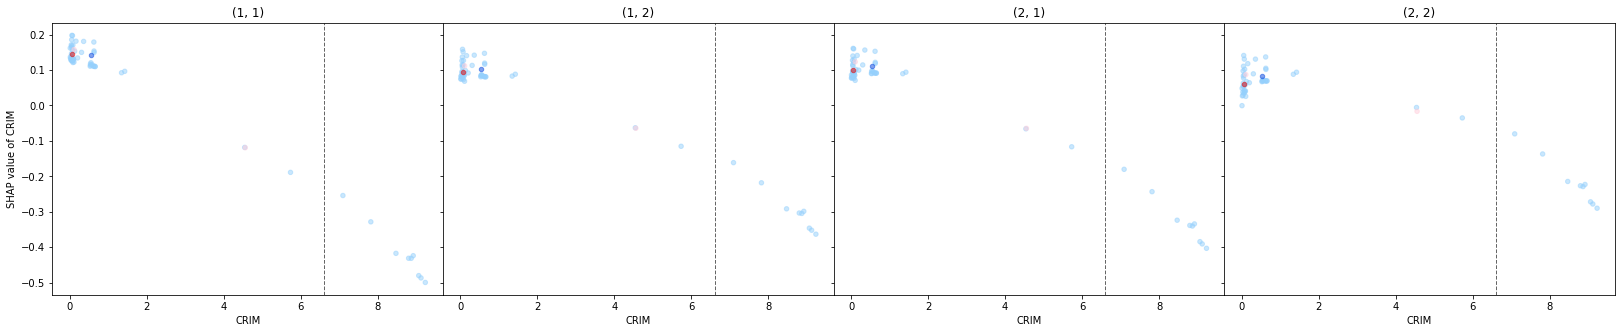

RM == 6.616
[Lower CF: RM == 6.5 --> {'(1, 1)': 1}, Upper CF: RM == 6.94 --> {'(2, 2)': 1}]


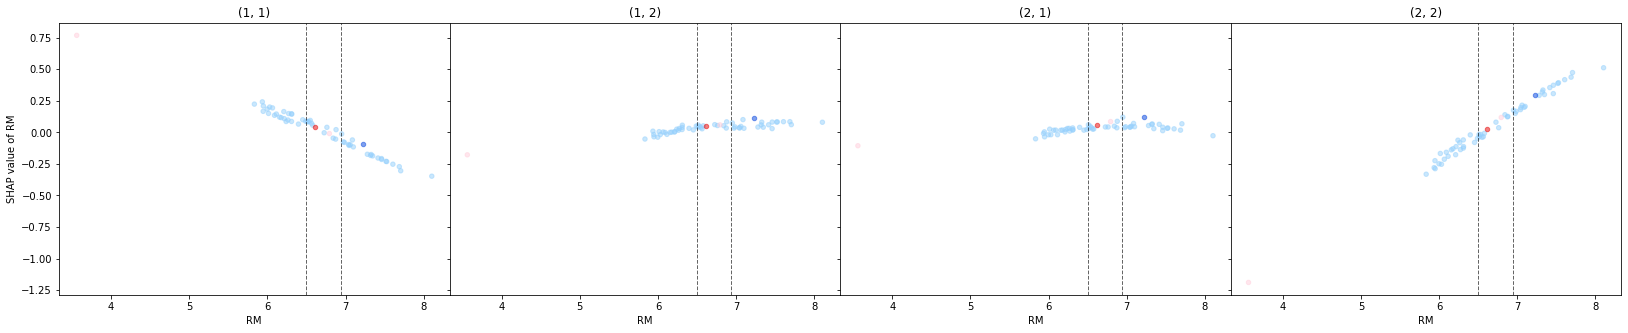

DIS == 3.37
[Lower CF: DIS == 2.62 --> {'(2, 2)': 1},
 Upper CF: DIS == 3.65 --> {'(1, 1)': 1}]


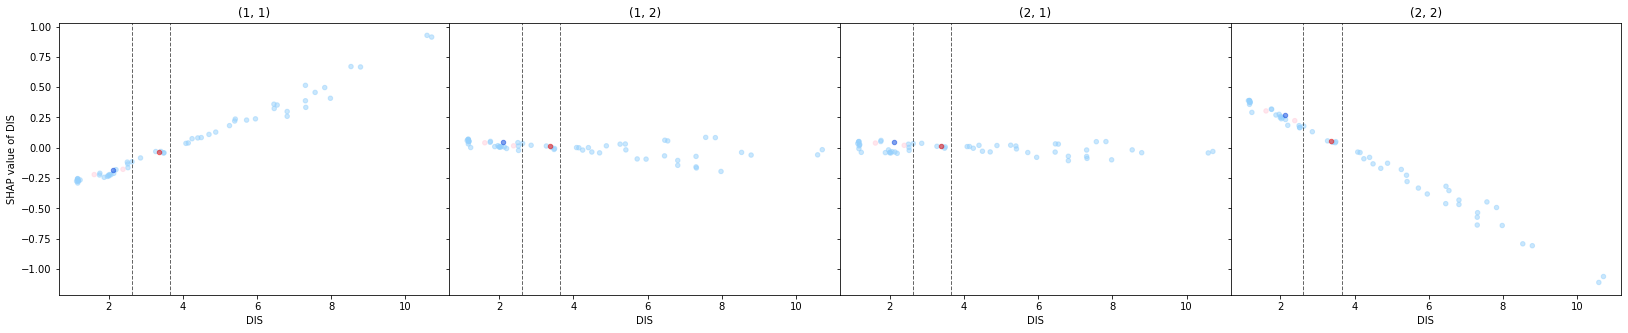

PTRATIO == 18.4
[]


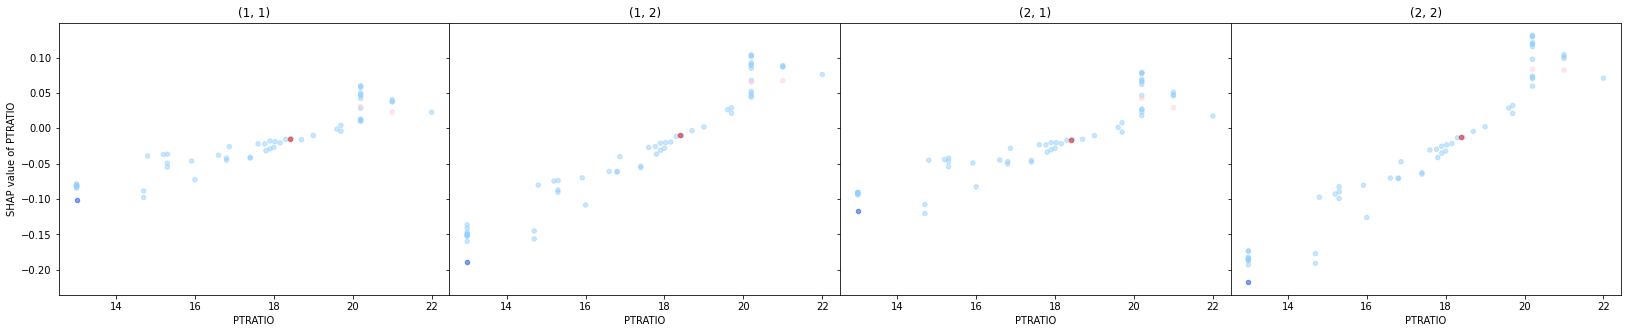

RAD == 7.0
[Lower CF: RAD == 6.39 --> {'(1, 1)': 1},
 Upper CF: RAD == 9.31 --> {'(2, 2)': 1}]


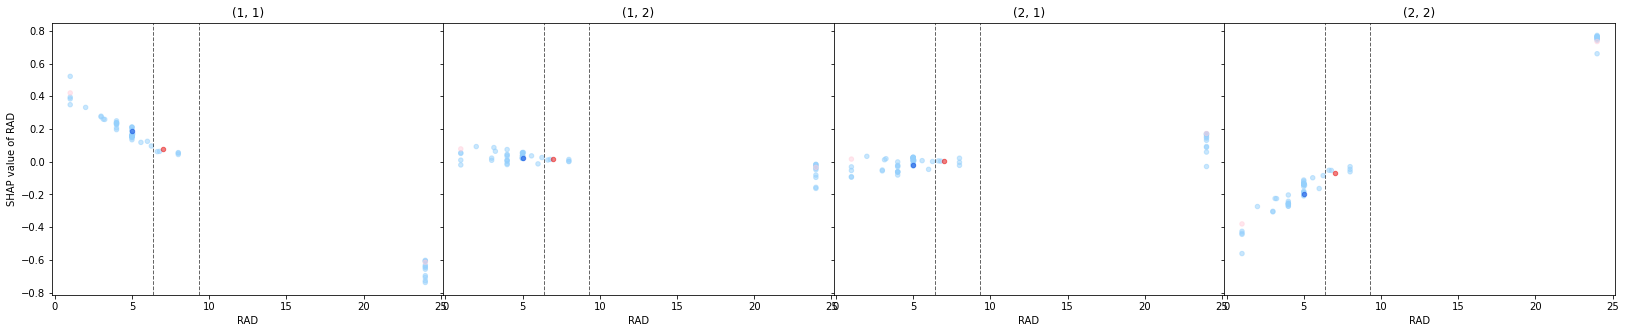

AGE == 1.0
[Lower CF: AGE == 0.0 --> {'(1, 2)': 1}]


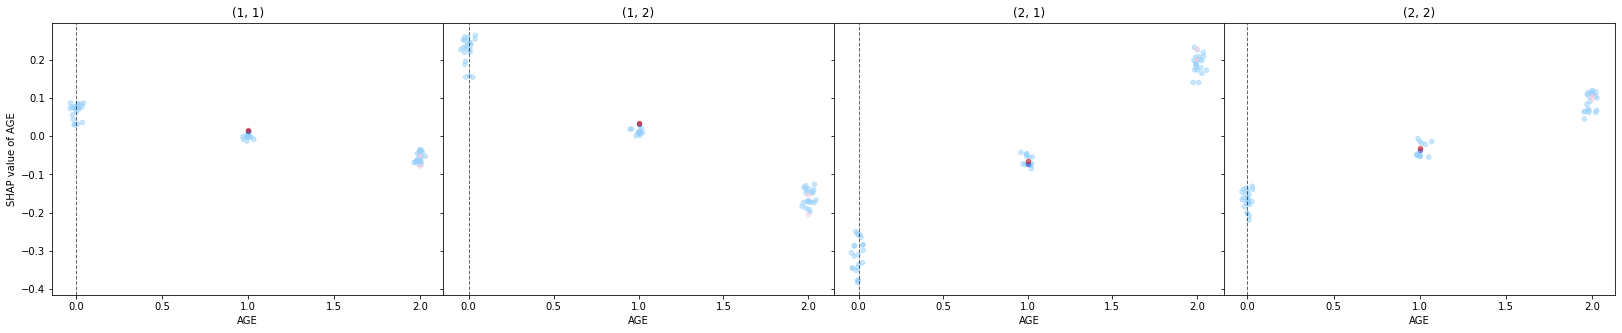

NOX == 0.472
[]


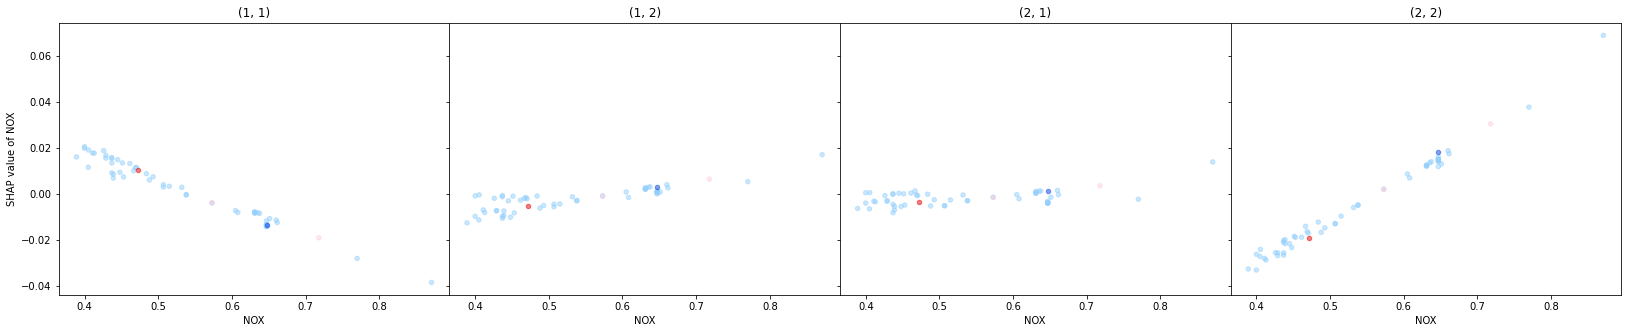

In [20]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)

### Node 2 (RRL)

In [21]:
node = path[-1].left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(RRL,
 (2, 2)    11
 (1, 1)     9
 (2, 1)     2
 (1, 2)     1
 dtype: int64,
 16.60871217301294)

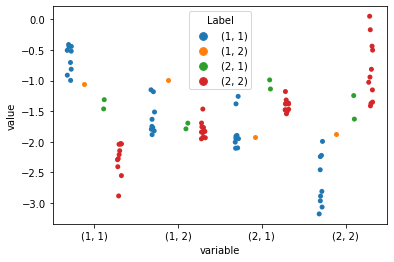

In [22]:
node.plot_outcomes(classes)

In [23]:
node.rule_from_counterfactuals()[0]

'5.97 < LSTAT <= 7.41 and 8.77 < INDUS <= 19.61 and CRIM <= 12.8 and DIS <= 4.17 and RM <= 7.21 and AGE > 1.0 and ZN <= 81.0'

6.48 <= LSTAT <= 7.12
[Lower CF: LSTAT == 5.97 --> {'(2, 2)': 2},
 Upper CF: LSTAT == 7.42 --> {'(1, 1)': 2}]


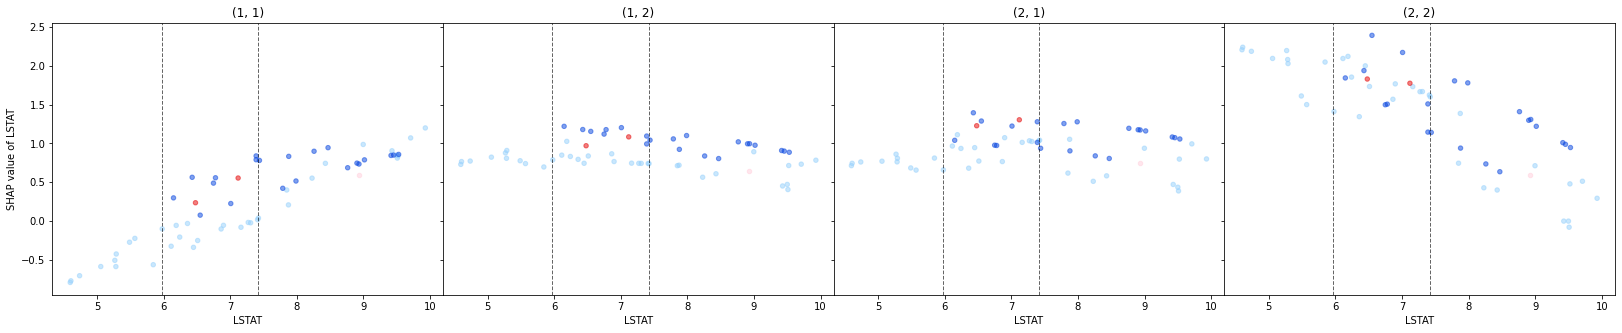

RAD
[]


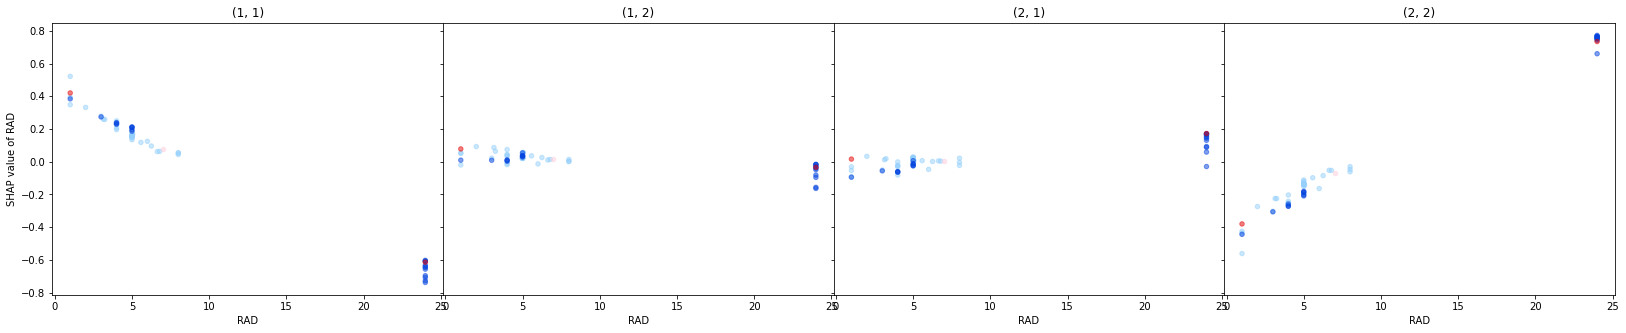

11.93 <= INDUS <= 18.1
[Lower CF: INDUS == 8.77 --> {'(2, 2)': 2},
 Upper CF: INDUS == 19.62 --> {'(1, 1)': 2}]


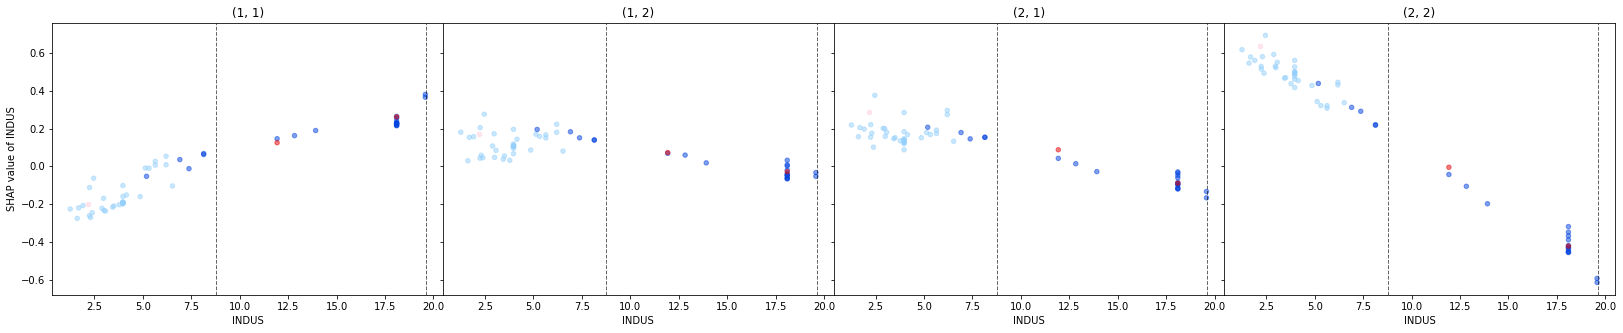

0.10959 <= CRIM <= 4.55587
[Upper CF: CRIM == 12.9 --> {'(2, 2)': 1, '(0, 1)': 1}]


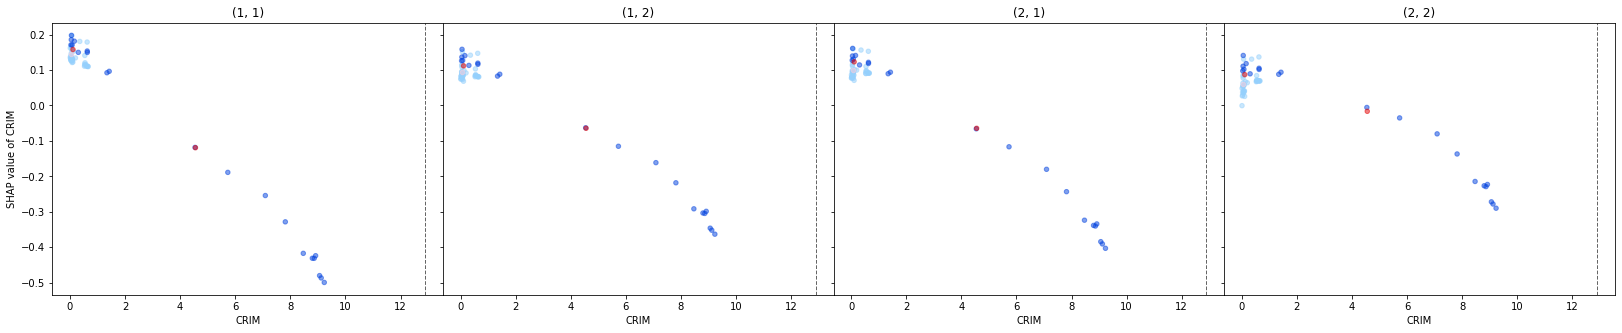

273.0 <= TAX <= 666.0
[]


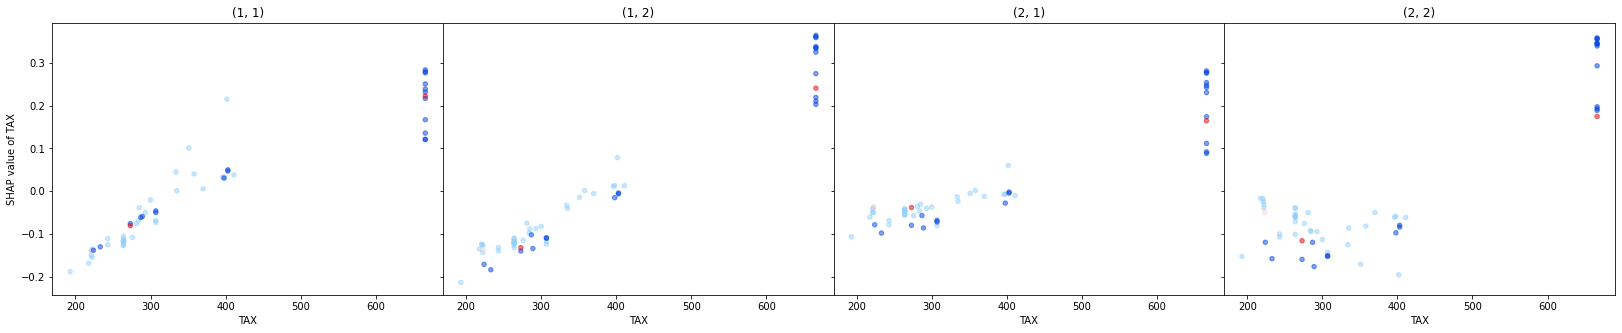

1.6132 <= DIS <= 2.3889
[Upper CF: DIS == 4.18 --> {'(1, 1)': 2}]


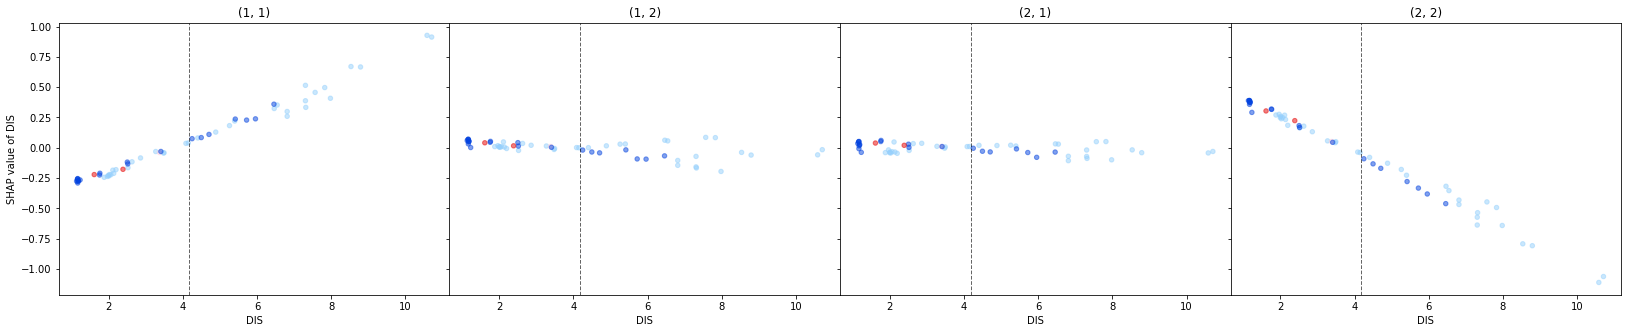

RM <= 6.794
[Upper CF: RM == 7.22 --> {'(2, 2)': 2}]


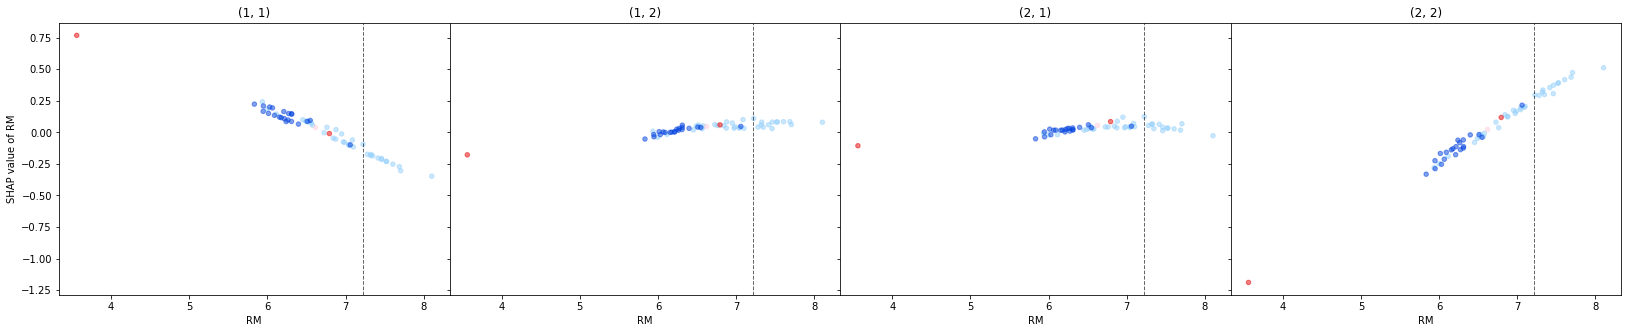

AGE == 2.0
[Lower CF: AGE == 1.0 --> {'(1, 2)': 1, '(1, 1)': 1}]


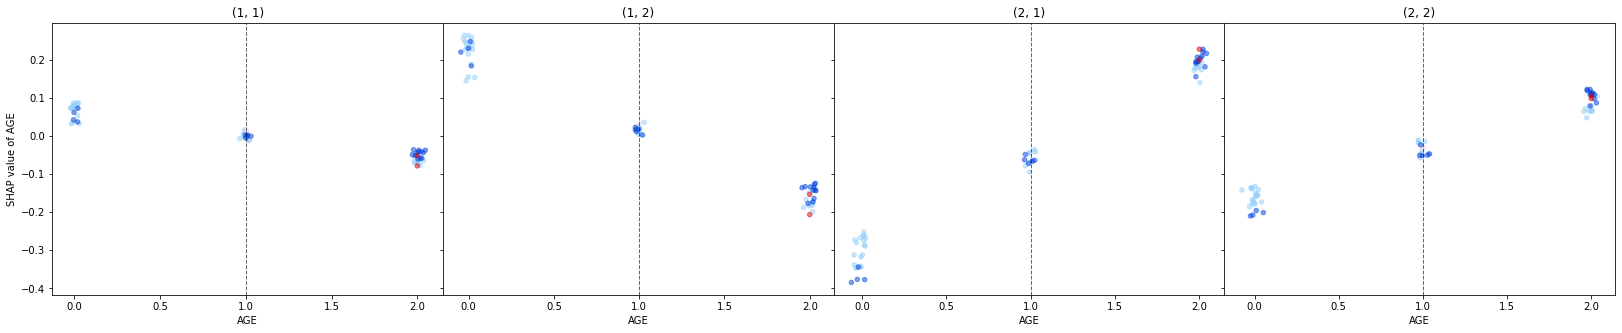

ZN == 0.0
[Upper CF: ZN == 82.0 --> {'(2, 2)': 2}]


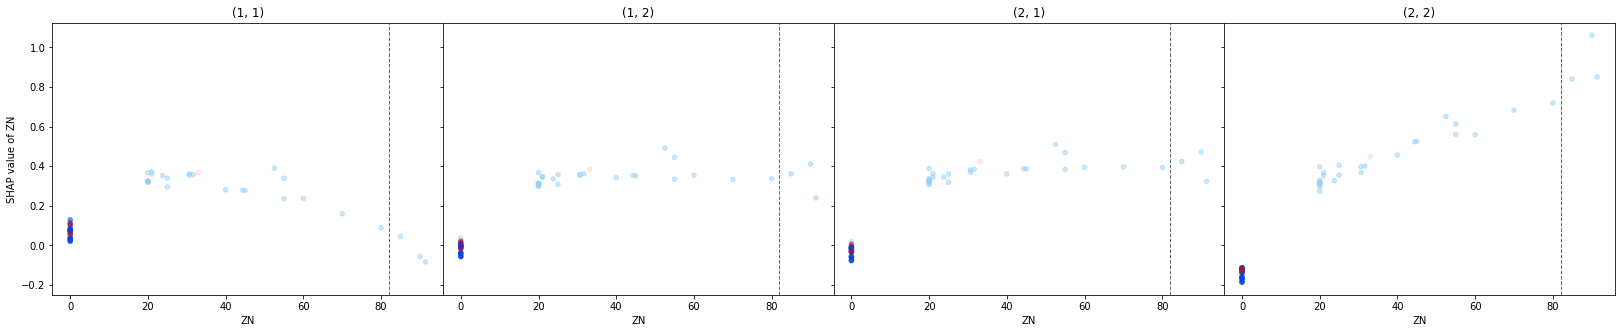

20.2 <= PTRATIO <= 21.0
[]


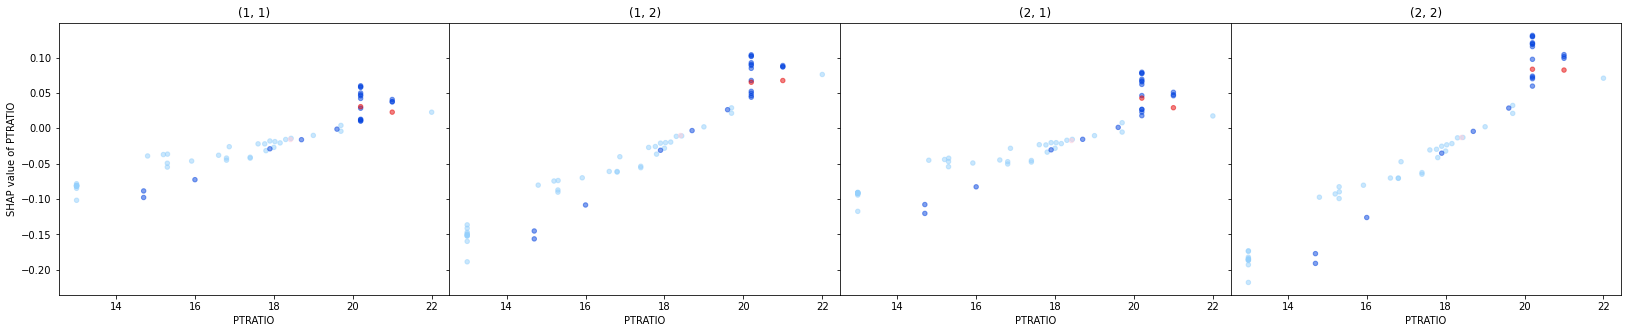

0.573 <= NOX <= 0.718
[]


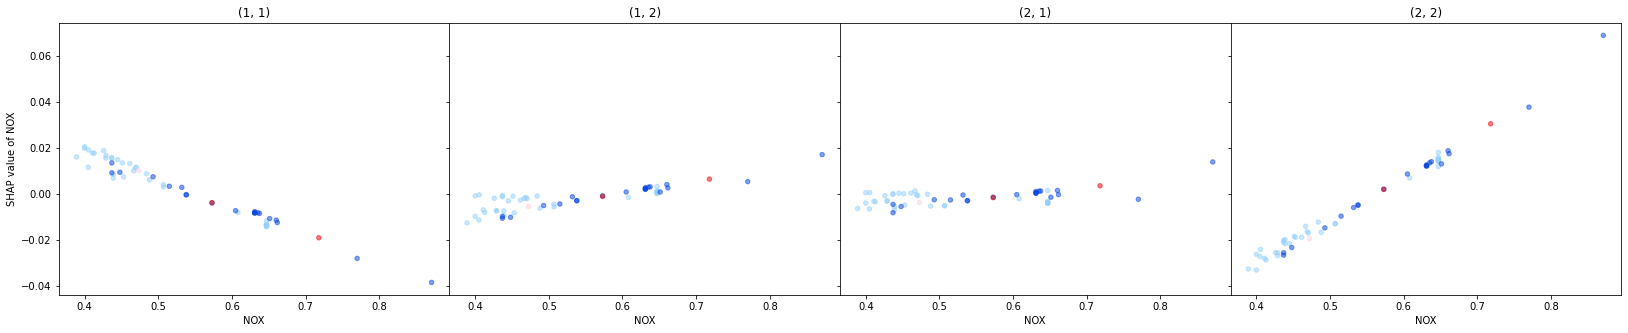

In [24]:
path[-1].plot_feature_dependence(focus=node, classes=classes, print_stats=True)